In [1]:
# Install and importing neccessary libraries
try:
    import polars as pl
except ImportError:
    !pip install polars
    import polars as pl
try:
    import geopandas as gpd
except ImportError:
    !pip install geopandas
    import geopandas as gpd
try:
    import folium
except ImportError:
    !pip install folium
    import folium

import branca.colormap as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
from datetime import datetime as dt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# Loading data
df_all = pl.read_parquet("./Data/Train/Train_2years.parquet")
df_dest = pl.read_parquet("./Data/Train/Train_2years_headsign.parquet")
df_all

Searched Station,Date,Train Nr.,Train Type,Departing Station,Scheduled Departure Time,Arrival Station,Scheduled Arrival Time,Actual Arrival Time,Delay,Cancellation,On Time,Departure Hour,Arrival Hour,Day of Week,Month,Year,Station Latitude,Station Longitude
str,date,str,str,str,datetime[μs],str,datetime[μs],datetime[μs],i64,i32,i32,i8,i8,i8,i8,i32,f64,f64
"""Landeck_Zams""",2024-09-30,"""RJX 869""","""RJX""","""Bregenz""",2024-09-30 12:40:00,"""Landeck-Zams""",2024-09-30 14:25:00,2024-09-30 14:27:00,2,0,1,12,14,1,9,2024,47.148287,10.578534
"""Wien_Hbf""",2025-01-08,"""RJ 130""","""RJ""","""Venezia Santa Lucia""",2025-01-08 15:52:00,"""Wien Hbf""",2025-01-08 23:36:00,2025-01-09 00:10:00,34,0,0,15,23,3,1,2025,48.185332,16.37865
"""Attnang_Puchheim""",2024-07-05,"""WB 917""","""WB""","""Salzburg Hbf""",2024-07-05 12:52:00,"""Attnang-Puchheim""",2024-07-05 13:35:00,2024-07-05 13:35:00,0,0,1,12,13,5,7,2024,48.012244,13.720598
"""Tullnerfeld""",2024-01-20,"""NJ 446""","""NJ""","""Wien Hbf (Autoreisezuganlage)""",2024-01-20 22:44:00,"""Tullnerfeld""",2024-01-20 23:19:00,2024-01-20 23:20:00,1,0,1,22,23,6,1,2024,48.295004,15.996219
"""Schärding""",2024-02-28,"""IC 296""","""IC""","""Fürth Hbf""",2024-02-28 00:33:00,"""Schärding""",2024-02-28 21:25:00,2024-02-28 21:25:00,0,0,1,0,21,3,2,2024,48.46422,13.442111
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Wien_Meidling""",2023-06-26,"""NJ 490""","""NJ""","""Wien Hbf""",2023-06-26 19:35:00,"""Wien Meidling""",2023-06-26 19:40:00,2023-06-26 19:41:00,1,0,1,19,19,1,6,2023,48.174652,16.333905
"""Wels_Hbf""",2023-05-25,"""RJX 42""","""RJX""","""Mosonmagyarovar""",2023-05-25 19:20:00,"""Wels Hbf""",2023-05-25 22:00:00,2023-05-25 22:00:00,0,0,1,19,22,4,5,2023,48.165701,14.026241
"""St._Pölten_Hbf""",2024-12-18,"""EN 406""","""EN""","""Zebrzydowice""",2024-12-18 04:26:00,"""St.Pölten Hbf""",2024-12-18 22:41:00,2024-12-18 23:20:00,39,0,0,4,22,3,12,2024,48.208325,15.62464


### Secondary preprocessing

In [3]:
# Fernverkehrszüge: https://www.oebb.at/de/reiseplanung-services/im-zug/unsere-zuege
trains = ["RJ", "RJX", "NJ", "IC", "ICE", "EC"]#, "D", "EN", "WB"]

df_fern = df_all.filter(
    pl.col("Train Type").is_in(trains)
)
df_dest= df_dest.filter(
    pl.col("Train Type").is_in(trains)
)

# ÖBB might not count cancellation as delay

df_fern_delay_without_cancel = df_fern.filter((pl.col("On Time") == 0) & (pl.col("Cancellation") == 0))
df_all_delay = df_all.filter(pl.col("On Time") == 0)
df_fern_delay = df_fern.filter(pl.col("On Time") == 0)
df_fern_cancel = df_fern.filter(pl.col("Cancellation") == 1)
df_dest_val = df_dest.filter(pl.col("trip_headsign").is_not_null()).rename({"trip_headsign": "Destination"}).unique(
    ["Searched Station", "Date", "Train Nr.", "Departing Station", "Scheduled Departure Time", "Arrival Station", "Scheduled Arrival Time", "Actual Arrival Time", "Station Latitude", "Station Longitude",	"Destination"]
)

### First Assessment

In [4]:
print("Size of Dataset (all):",len(df_all))
print("Size of Dataset (Long-Distance):",len(df_fern))

Size of Dataset (all): 2544010
Size of Dataset (Long-Distance): 1983228


In [5]:
unique = df_fern.select(
    pl.col("Date").n_unique().alias("unique date"),
    pl.col("Arrival Station").n_unique().alias("unique station")
)
print(unique)

value = df_fern.select(
    pl.col("Arrival Station").value_counts().alias("value station")
).sort("value station")
print(value)

shape: (1, 2)
┌─────────────┬────────────────┐
│ unique date ┆ unique station │
│ ---         ┆ ---            │
│ u32         ┆ u32            │
╞═════════════╪════════════════╡
│ 762         ┆ 310            │
└─────────────┴────────────────┘
shape: (310, 1)
┌────────────────────────────────┐
│ value station                  │
│ ---                            │
│ struct[2]                      │
╞════════════════════════════════╡
│ {"Absdorf-Hippersdorf",480}    │
│ {"Allentsteig",1}              │
│ {"Altmünster am Traunsee",865} │
│ {"Amstetten NÖ",35022}         │
│ {"Ardning",2}                  │
│ …                              │
│ {"Zell am See",3695}           │
│ {"Zellerndorf",1}              │
│ {"Zeltweg",1}                  │
│ {"Ziersdorf",482}              │
│ {"Ötztal",17406}               │
└────────────────────────────────┘


In [6]:
delay = df_fern.select(
    pl.col("Delay").value_counts()
).sort("Delay")

print(delay)

shape: (511, 1)
┌──────────────┐
│ Delay        │
│ ---          │
│ struct[2]    │
╞══════════════╡
│ {null,30526} │
│ {0,782119}   │
│ {1,394271}   │
│ {2,133484}   │
│ {3,92342}    │
│ …            │
│ {859,1}      │
│ {884,5}      │
│ {914,1}      │
│ {935,1}      │
│ {945,10}     │
└──────────────┘


In [7]:
spezific_city_date_counts = df_fern.filter(pl.col("Arrival Station") == "Wien Hbf").group_by("Date").agg(
    pl.len().alias("count")
).sort("count", descending = True)           

print(spezific_city_date_counts)

shape: (731, 2)
┌────────────┬───────┐
│ Date       ┆ count │
│ ---        ┆ ---   │
│ date       ┆ u32   │
╞════════════╪═══════╡
│ 2024-09-05 ┆ 187   │
│ 2024-09-12 ┆ 185   │
│ 2024-09-13 ┆ 185   │
│ 2024-09-03 ┆ 184   │
│ 2024-09-06 ┆ 184   │
│ …          ┆ …     │
│ 2024-10-29 ┆ 132   │
│ 2024-10-30 ┆ 128   │
│ 2024-10-31 ┆ 127   │
│ 2023-09-09 ┆ 124   │
│ 2025-01-27 ┆ 94    │
└────────────┴───────┘


### Data Validity

Zugfinder

In [8]:
# https://www.zugfinder.net/de/bahnhofstafel-Graz_Hbf-20240101-arr
# Average Delay: 2 Minutes; Punctuality: 95%
# https://www.zugfinder.net/de/bahnhofstafel-Innsbruck_Hbf-20230606-arr
# Average Delay: 11 Minutes; Punctuality: 66%

df_wien_delay_2024 = df_all_delay.filter((pl.col("Arrival Station") == "Graz Hbf") & (pl.col("Date") == pl.date(2024, 1, 1)))
df_wien_2024 = df_all.filter((pl.col("Arrival Station") == "Graz Hbf") & (pl.col("Date") == pl.date(2024, 1, 1)))
df_wien_delay_2023 = df_all_delay.filter((pl.col("Arrival Station") == "Innsbruck Hbf") & (pl.col("Date") == pl.date(2023, 6, 6)))
df_wien_2023 = df_all.filter((pl.col("Arrival Station") == "Innsbruck Hbf") & (pl.col("Date") == pl.date(2023, 6, 6)))

# Average Delay
avg_delay_2024 = df_wien_2024.select(
    pl.col("Delay").mean().round(1).alias("avg_delay")
).item()
avg_delay_2023 = df_wien_2023.select(
    pl.col("Delay").mean().round(1).alias("avg_delay")
).item()

# Punctuality
punc_2024 = round(((1 - len(df_wien_delay_2024) / len(df_wien_2024)) * 100), 2)
punc_2023 = round(((1 - len(df_wien_delay_2023) / len(df_wien_2023)) * 100), 2)
print("2024:")
print("Average Delay (Zugfinder): 2 Minutes; Average Delay (Calculated):", avg_delay_2024, "Minutes")
print("Punctuality (Zugfinder): 95 %; Punctuality (Calculated):", punc_2024, "%")
print("2023:")
print("Average Delay (Zugfinder): 11 Minutes; Average Delay (Calculated):", avg_delay_2023, "Minutes")
print("Punctuality (Zugfinder): 66 %; Punctuality (Calculated):", punc_2023, "%")

2024:
Average Delay (Zugfinder): 2 Minutes; Average Delay (Calculated): 1.5 Minutes
Punctuality (Zugfinder): 95 %; Punctuality (Calculated): 94.74 %
2023:
Average Delay (Zugfinder): 11 Minutes; Average Delay (Calculated): 11.4 Minutes
Punctuality (Zugfinder): 66 %; Punctuality (Calculated): 65.71 %


ÖBB

In [9]:
# https://infrastruktur.oebb.at/dam/jcr:03a3177a-b9a6-41aa-91cb-43d8e289b11f/zahlen-daten-fakten-folder-2024-oebb.pdf
# Punctuality 2024: 81% 
# https://presse.oebb.at/dam/jcr:49fcfbe2-b901-4091-8d79-883fb1dddbd2/OEBB_CSR2023_D_web.pdf
# Punctuality 2023: 80,3%

df_fern_delay_2024 = df_fern_delay_without_cancel.filter(pl.col("Year") == 2024)
df_fern_2024 = df_fern.filter(pl.col("Year") == 2024)
df_fern_delay_2023 = df_fern_delay_without_cancel.filter(pl.col("Year") == 2023)
df_fern_2023 = df_fern.filter(pl.col("Year") == 2023)

punc_öbb_2024 = round(((1 - len(df_fern_delay_2024) / len(df_fern_2024)) * 100), 2)
punc_öbb_2023 = round(((1 - len(df_fern_delay_2023) / len(df_fern_2023)) * 100), 2)

print("Punctuality 2023 (ÖBB): 80,3 %; Punctuality 2023 (Calculated):", punc_öbb_2023, "%")
print("Punctuality 2024 (ÖBB): 81 %; Punctuality 2024 (Calculated):", punc_öbb_2024, "%")

Punctuality 2023 (ÖBB): 80,3 %; Punctuality 2023 (Calculated): 78.75 %
Punctuality 2024 (ÖBB): 81 %; Punctuality 2024 (Calculated): 78.17 %


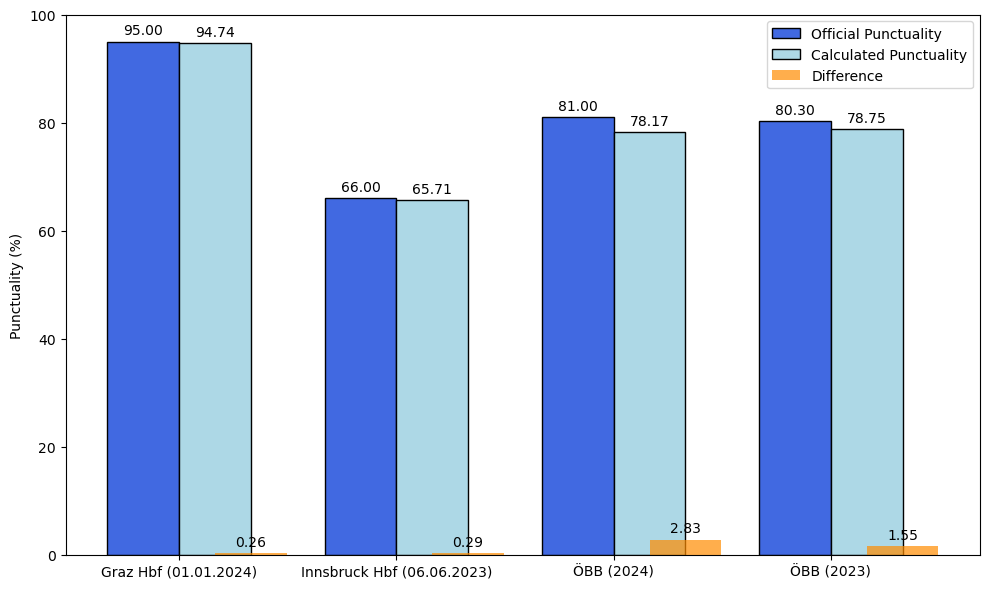

In [10]:
stations = ["Graz Hbf (01.01.2024)", "Innsbruck Hbf (06.06.2023)", "ÖBB (2024)", "ÖBB (2023)"]
official_punctuality = np.array([95, 66, 81, 80.3])
calculated_punctuality = np.array([punc_2024, punc_2023, punc_öbb_2024, punc_öbb_2023])
punctuality_diff = abs(official_punctuality - calculated_punctuality)

bar_width = 0.33
x = np.arange(len(stations))

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - bar_width / 2, official_punctuality, bar_width, label = "Official Punctuality", color = "royalblue", edgecolor = "black")
bars2 = ax.bar(x + bar_width / 2, calculated_punctuality, bar_width, label = "Calculated Punctuality", color = "lightblue", edgecolor = "black")
bars3 = ax.bar(x + bar_width, punctuality_diff, bar_width, label = "Difference", color = "darkorange", alpha = 0.7)
ax.bar_label(bars1, padding = 3, fmt = "%.2f")
ax.bar_label(bars2, padding = 3, fmt = "%.2f")
ax.bar_label(bars3, padding = 3, fmt = "%.2f")
ax.set_ylabel("Punctuality (%)")
ax.set_ylim(0, 100)
ax.set_xticks(x)
ax.set_xticklabels(stations)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Statistics

Amount of arrivals per Station

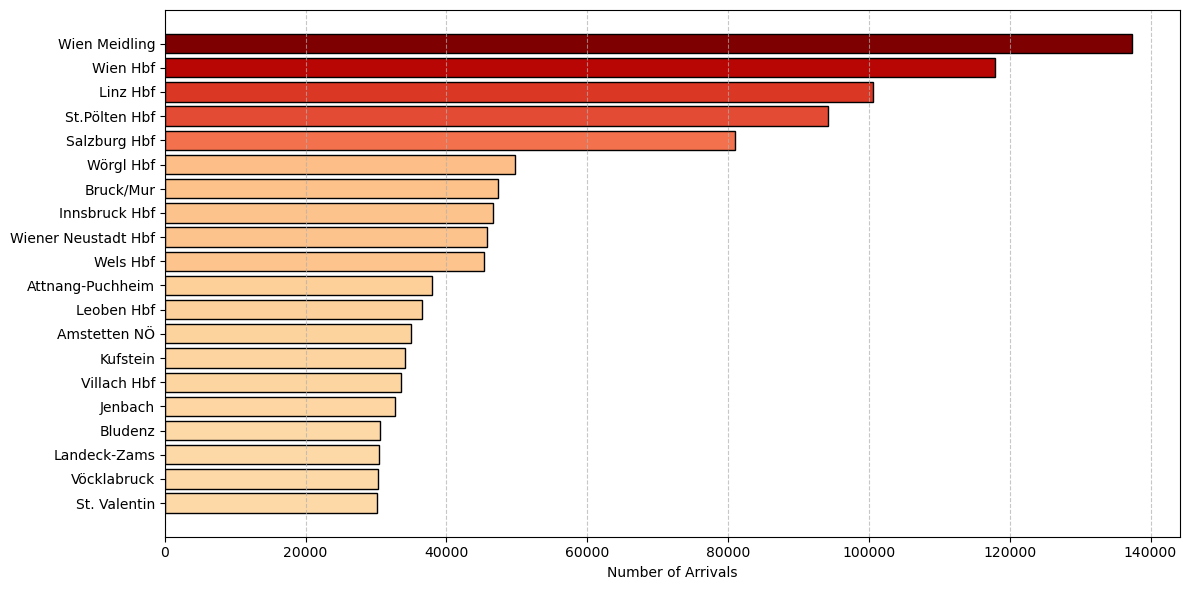

In [11]:
station_count = df_fern.group_by("Arrival Station").agg(
    pl.count("Train Nr.").alias("train_count")
).sort("train_count", descending = True)
#print(station_counts)

station_count_top = station_count.head(20)
fig, ax = plt.subplots(figsize = (12, 6))

norm = plt.Normalize(station_count["train_count"].min(), station_count["train_count"].max())
colors = plt.cm.OrRd(norm(station_count["train_count"]))
bars = ax.barh(station_count_top["Arrival Station"].cast(pl.String), station_count_top["train_count"], color = colors, edgecolor = "black")

ax.invert_yaxis()
ax.grid(axis = "x", linestyle = "--", alpha = 0.7)
ax.set_xlabel("Number of Arrivals")

plt.tight_layout()
plt.show()

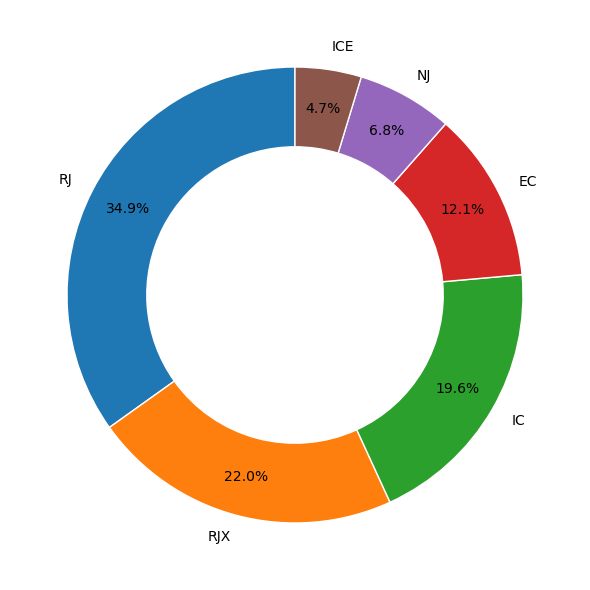

In [12]:
train_percent = df_fern.group_by("Train Type").agg([
    pl.len().alias("type_count")
])
train_percent = train_percent.with_columns(
    (pl.col("type_count") / pl.col("type_count").sum() * 100).round(1).alias("percentage")
).sort("percentage", descending = True)
#print(train_percent)

fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(
    train_percent["percentage"],
    labels = train_percent["Train Type"],
    autopct = "%1.1f%%",
    startangle = 90,
    pctdistance = 0.825,
    wedgeprops = {"width": 0.35, "linewidth": 1, "edgecolor": "white"},
)

plt.tight_layout()
plt.show()

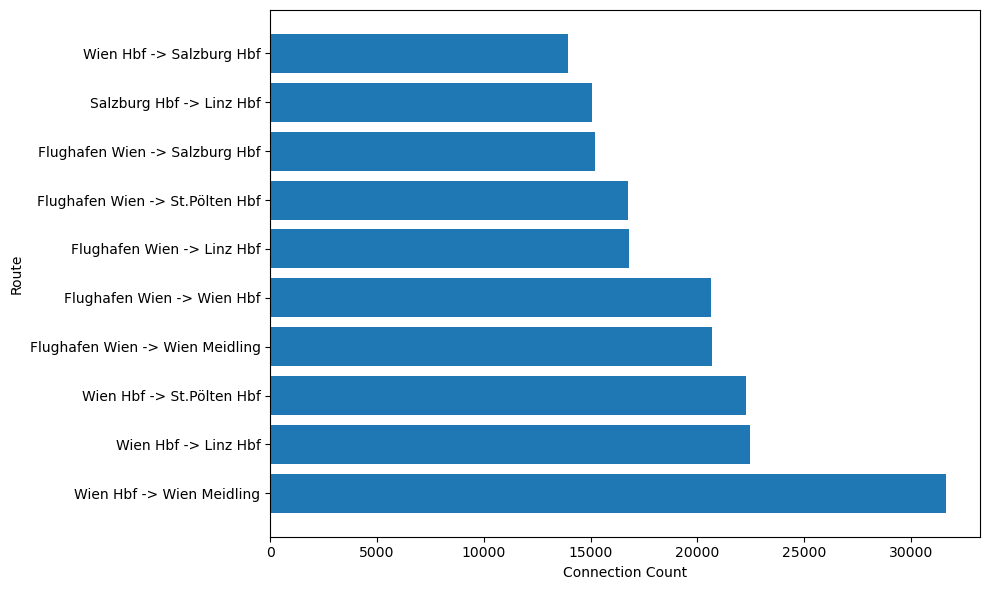

In [13]:
connection_count = df_fern.group_by(
    ["Departing Station", "Arrival Station"]
).agg(
    pl.count("Train Nr.").alias("connection_count")
).sort("connection_count", descending = True)

connection_count = connection_count.with_columns(
    (pl.col("Departing Station") + " -> " + pl.col("Arrival Station")).alias("connection")
)
#print(connection_count)

connection_count_top = connection_count.head(10)
plt.figure(figsize = (10,6))
plt.barh(connection_count_top["connection"], connection_count_top["connection_count"])
plt.xlabel("Connection Count")
plt.ylabel("Route")
plt.tight_layout()
plt.show()

### Delay Analysis  
Delayed trains, without cancellation

Delay by Train Nr.

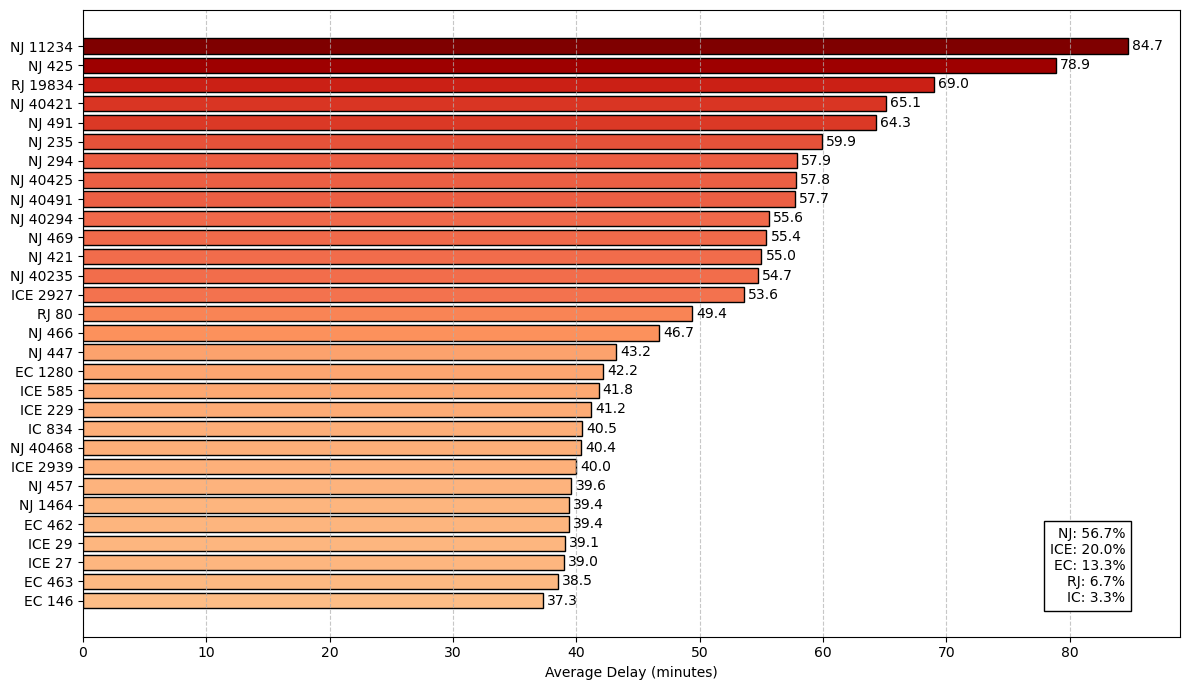

In [14]:
delay_by_train = df_fern_delay_without_cancel.group_by("Train Nr.").agg([
    pl.col("Delay").mean().round(1).alias("avg_delay"),
    pl.len().alias("ride_count"),
    pl.col("Train Type").first().alias("Train Type") 
]).filter(pl.col("ride_count") > 50).drop("ride_count").sort("avg_delay", descending=True)

delay_by_train_top = delay_by_train.head(30)
train_type_count = delay_by_train_top.group_by("Train Type").agg([
        pl.len().alias("count")
]).with_columns(
    (pl.col("count") / len(delay_by_train_top) * 100).round(1).alias("percentage")
).sort("percentage", descending = True)

percentage_text = train_type_count.select(
    pl.format(
        "{}: {}%",
        pl.col("Train Type"),
        pl.col("percentage")
    )
).to_series().str.concat("\n")[0]

fig, ax = plt.subplots(figsize = (12, 7))

norm = plt.Normalize(delay_by_train["avg_delay"].min(), delay_by_train["avg_delay"].max())
colors = plt.cm.OrRd(norm(delay_by_train["avg_delay"]))
bars = ax.barh(delay_by_train_top["Train Nr."].cast(pl.String), delay_by_train_top["avg_delay"], color = colors, edgecolor = "black")

ax.invert_yaxis()
ax.grid(axis = "x", linestyle = "--", alpha = 0.7)
ax.bar_label(bars, padding = 3, fmt = "%.1f")
ax.set_xlabel("Average Delay (minutes)")

ax.text(0.95, 0.05, 
        percentage_text, 
        transform = ax.transAxes, 
        fontsize = 10,
        va = "bottom",
        ha = "right",
        bbox = dict(facecolor = "white", edgecolor = "black")
       )

plt.tight_layout()
plt.show()

Delay by Station

In [15]:
delay_by_station = df_fern_delay_without_cancel.group_by("Arrival Station").agg([
    pl.col("Delay").mean().round(2).alias("avg_delay"),
    pl.len().alias("station_count"),
    pl.col("Station Latitude").first().alias("Latitude"),
    pl.col("Station Longitude").first().alias("Longitude")
]).filter(pl.col("station_count") > 100).sort("avg_delay", descending = True)
#print(delay_by_station)

# Create map with center in Austria
m = folium.Map(location = [47.5, 13.3], zoom_start = 8, control_scale = True)

# Add colorscale for average delay
colorscale = cm.LinearColormap(
    colors=["yellow", "red"],
    vmin = delay_by_station["avg_delay"].min(),
    vmax = delay_by_station["avg_delay"].max(),
    caption = "Average Delay (minutes)"
)
colorscale.add_to(m)

# Plot the stations
for row in delay_by_station.iter_rows(named = True):
    folium.CircleMarker(
        location = [row["Latitude"], row["Longitude"]],
        radius = row["station_count"] * 0.0014, 
        color = colorscale(row["avg_delay"]),
        fill = True,
        fill_color = colorscale(row["avg_delay"]),
        fill_opacity = 0.6,
        popup = (f"Station: {row["Arrival Station"]}<br>"
                 f"Average Delay: {row["avg_delay"]} minutes<br>"
                 f"Station Count: {row["station_count"]}"),
        tooltip = f"Click: {row["Arrival Station"]}"
    ).add_to(m)

# Include name for top 10 busiest stations
top_10 = delay_by_station.sort("avg_delay", descending = True).head(10)
for row in top_10.iter_rows(named = True):
    folium.Marker(
        location = [row["Latitude"], row["Longitude"]],
        icon = folium.DivIcon(
            html = (
                f"<div style='font-size: 10pt; "
                f"transform: rotate(345deg); "
                f"font-weight:bold; "
                f"padding: 2px;'>"
                f"{row["Arrival Station"]}"
                f"</div>"
            )
        )
    ).add_to(m)

m

In [16]:
m.save("./Data/Train/Maps/Avg_Delay_Austrian_Station.html")

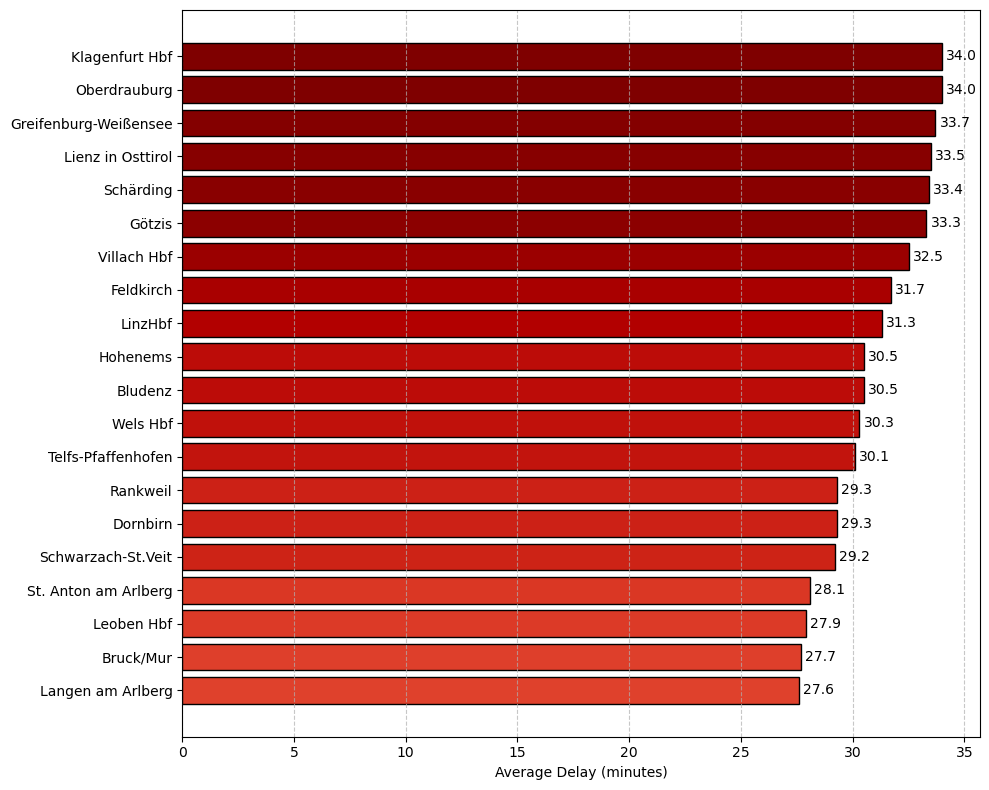

In [17]:
delay_by_station = df_fern_delay_without_cancel.group_by("Arrival Station").agg([
        pl.col("Delay").mean().round(1).alias("avg_delay"), 
        pl.len().alias("station_count") 
]).filter(pl.col("station_count") > 100).drop("station_count").sort("avg_delay", descending = True)
#print(delay_by_station)

delay_by_station_top = delay_by_station.head(20)
fig, ax = plt.subplots(figsize = (10, 8))

norm = plt.Normalize(delay_by_station["avg_delay"].min(), delay_by_station["avg_delay"].max())
colors = plt.cm.OrRd(norm(delay_by_station["avg_delay"]))
bars = ax.barh(delay_by_station_top["Arrival Station"], delay_by_station_top["avg_delay"], color = colors,edgecolor = "black")

ax.invert_yaxis()
ax.grid(axis = "x", linestyle = "--", alpha = 0.7)
ax.bar_label(bars, padding = 3, fmt = "%.1f")
ax.set_xlabel("Average Delay (minutes)")

plt.tight_layout()
plt.show()

Delay by Time of Day

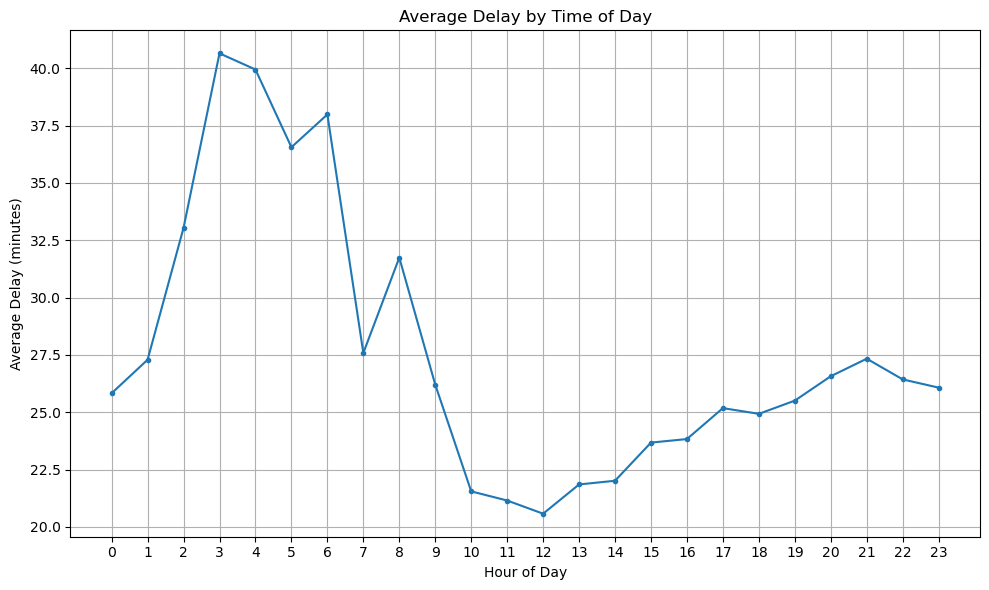

In [18]:
delay_by_hour = df_fern_delay_without_cancel.group_by("Arrival Hour").agg(
    pl.col("Delay").mean().alias("avg_delay")
).sort("Arrival Hour")
#print(delay_by_hour)

plt.figure(figsize = (10,6))
plt.plot(delay_by_hour["Arrival Hour"], delay_by_hour["avg_delay"], marker = ".")
plt.xlabel("Hour of Day")
plt.ylabel("Average Delay (minutes)")
plt.title("Average Delay by Time of Day")
plt.xticks(range(0,24))
plt.grid(True)
plt.tight_layout()
plt.show()

Delay by Day of Week

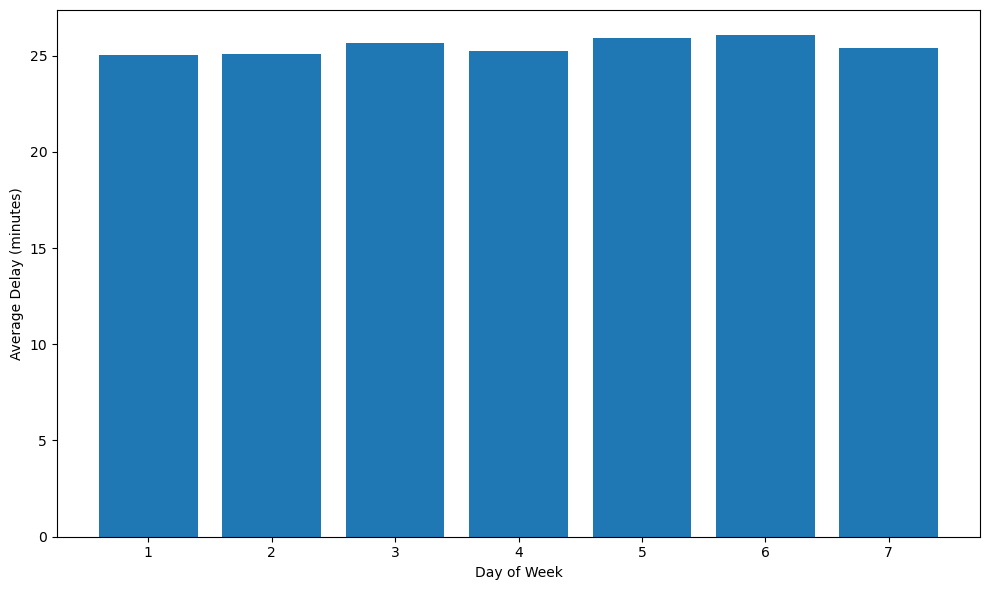

In [19]:
delay_by_day = df_fern_delay_without_cancel.group_by("Day of Week").agg(
    pl.col("Delay").mean().alias("avg_delay")
).sort("Day of Week")
#print(delay_by_day)

plt.figure(figsize = (10,6))
plt.bar (delay_by_day["Day of Week"], delay_by_day["avg_delay"])
plt.xlabel("Day of Week")
plt.ylabel("Average Delay (minutes)")
plt.tight_layout()
plt.show()

Delay by Date

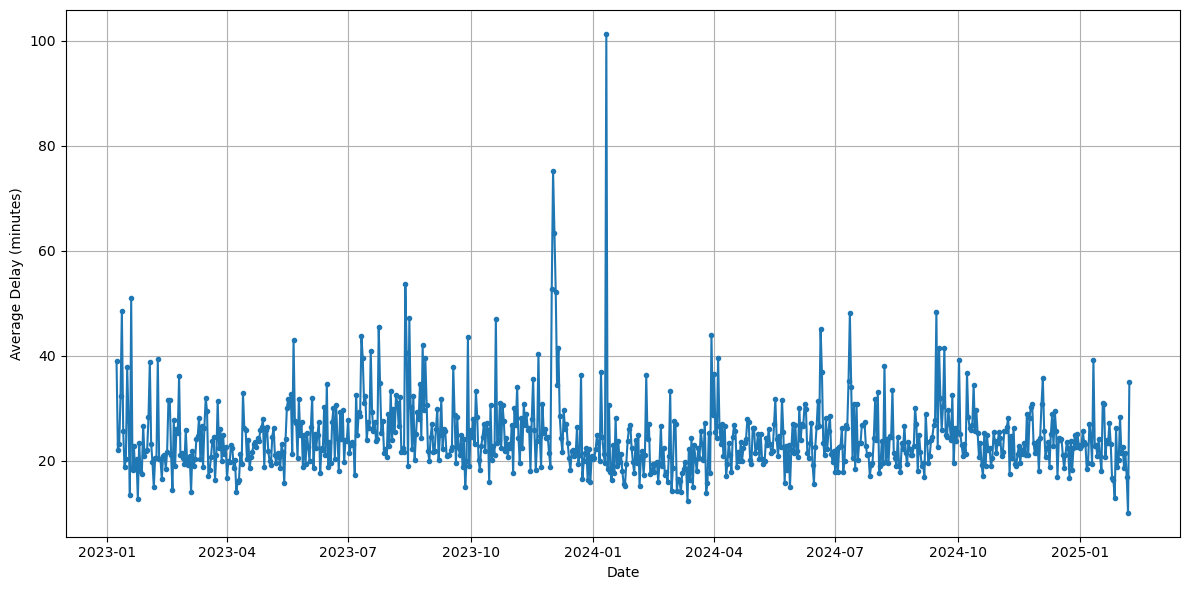

In [20]:
delay_by_date = df_fern_delay_without_cancel.group_by("Date").agg(
    pl.col("Delay").mean().alias("avg_delay")
).sort("Date")
#print(delay_by_day)

plt.figure(figsize = (12,6))
plt.plot(delay_by_date["Date"], delay_by_date["avg_delay"], marker = ".")
plt.xlabel("Date")
plt.ylabel("Average Delay (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()

Delay by Month

This differentiation between the years could be done for every plot

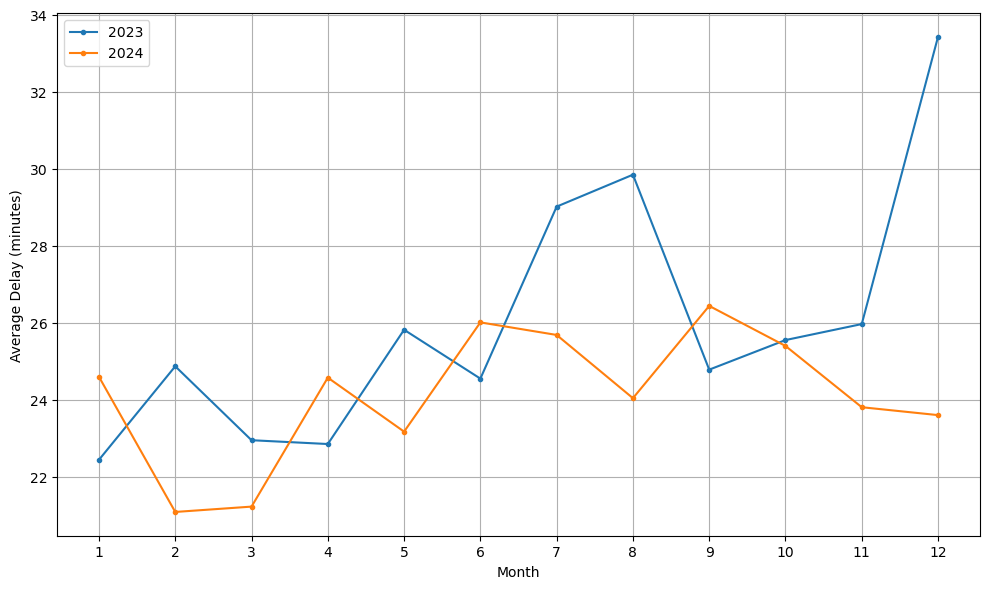

In [21]:
delay_by_month_2023 = df_fern_delay_without_cancel.filter(pl.col("Year") == 2023).group_by("Month").agg(
    pl.col("Delay").mean().alias("avg_delay")
).sort("Month")
delay_by_month_2024 = df_fern_delay_without_cancel.filter(pl.col("Year") == 2024).group_by("Month").agg(
    pl.col("Delay").mean().alias("avg_delay")
).sort("Month")

plt.figure(figsize = (10,6))
plt.plot(delay_by_month_2023["Month"], delay_by_month_2023["avg_delay"], marker = ".", label = 2023)
plt.plot(delay_by_month_2024["Month"], delay_by_month_2024["avg_delay"], marker = ".", label = 2024)
plt.xlabel("Month")
plt.ylabel("Average Delay (minutes)")
plt.xticks(range(1,13))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Heatmap of Average Delay by Date and Arrival Hour 

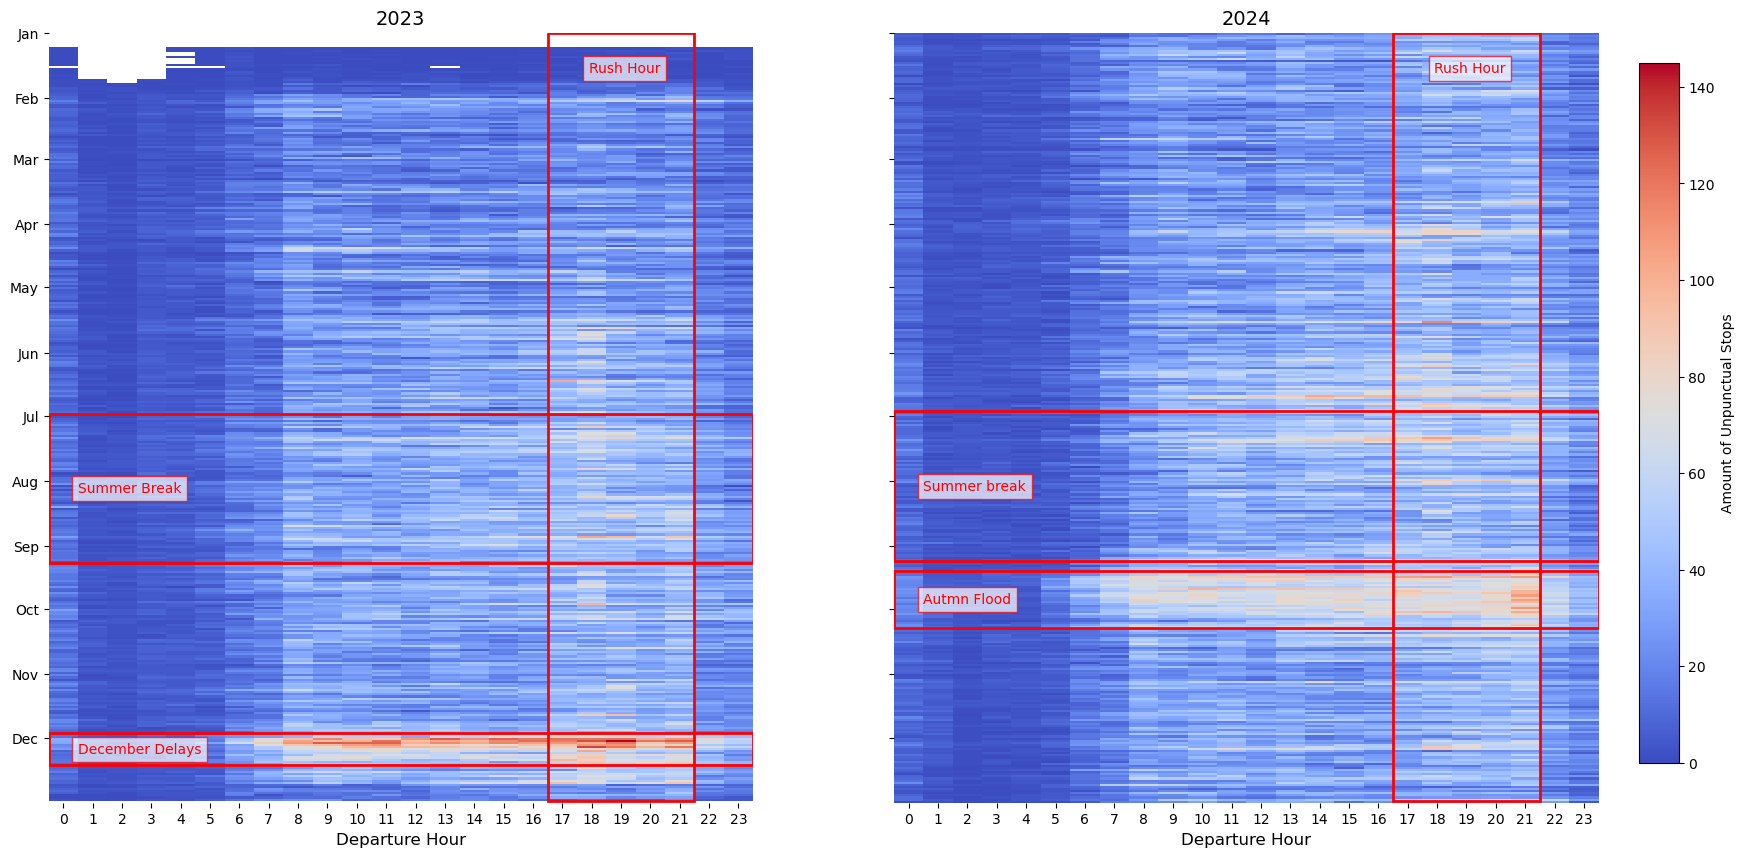

In [22]:
delay_by_date_hour_2023 = df_fern.filter(pl.col("Year") == 2023).group_by(["Date", "Arrival Hour"]).agg(
    (pl.col("On Time") == 0).sum().alias("count")
).sort(["Date", "Arrival Hour"])
delay_by_date_hour_2024 = df_fern.filter(pl.col("Year") == 2024).group_by(["Date", "Arrival Hour"]).agg(
    (pl.col("On Time") == 0).sum().alias("count")
).sort(["Date", "Arrival Hour"])

# seaborn heatmap needs pandas
delay_by_date_hour_pd_2023 = delay_by_date_hour_2023.to_pandas()
delay_by_date_hour_pd_2024 = delay_by_date_hour_2024.to_pandas()

heatmap_data_2023 = delay_by_date_hour_pd_2023.pivot(index = "Date", columns = "Arrival Hour", values = "count")
heatmap_data_2024 = delay_by_date_hour_pd_2024.pivot(index = "Date", columns = "Arrival Hour", values = "count")

heatmap_data_2023.index = pd.to_datetime(heatmap_data_2023.index)
heatmap_data_2024.index = pd.to_datetime(heatmap_data_2024.index)

# Make sure both years are of the same length
heatmap_data_2023.index = pd.to_datetime(heatmap_data_2023.index)
full_dates_2023 = pd.date_range(start = "2023-01-01", end = "2023-12-31", freq = "D")
heatmap_data_2023 = heatmap_data_2023.reindex(full_dates_2023)
heatmap_data_2024.index = pd.to_datetime(heatmap_data_2024.index)
full_dates_2024 = pd.date_range(start = "2024-01-01", end = "2024-12-31", freq = "D")
heatmap_data_2024 = heatmap_data_2024.reindex(full_dates_2024)

vmin = min(delay_by_date_hour_pd_2023["count"].min(), 
           delay_by_date_hour_pd_2024["count"].min())
vmax = max(delay_by_date_hour_pd_2023["count"].max(), 
           delay_by_date_hour_pd_2024["count"].max())
norm = plt.Normalize(vmin = vmin, vmax = vmax)

fig, axes = plt.subplots(1, 2, figsize = (20, 10), sharey = True)

# Heatmap 2023
sns.heatmap(
    heatmap_data_2023, 
    cmap = "coolwarm", 
    ax = axes[0], 
    cbar = False,  
    yticklabels = False,
    norm = norm,
    vmin = vmin, 
    vmax = vmax
)
# Heatmap 2024
sns.heatmap(
    heatmap_data_2024, 
    cmap = "coolwarm", 
    ax = axes[1], 
    cbar = False, 
    yticklabels = False,
    norm = norm,
    vmin = vmin,
    vmax = vmax
)

# Legend
sm = plt.cm.ScalarMappable(norm = norm, cmap = "coolwarm")
sm.set_array([])
fig.colorbar(sm, cax = fig.add_axes([0.92, 0.15, 0.02, 0.7]), label = "Amount of Unpunctual Stops")
# X-Axis
axes[0].set_title("2023", fontsize = 14)
axes[1].set_title("2024", fontsize = 14)
axes[0].set_xlabel("Departure Hour", fontsize = 12)
axes[1].set_xlabel("Departure Hour", fontsize = 12)
# Y-Axis
ticks = np.where(heatmap_data_2024.index.day == 1)[0]
labels = heatmap_data_2024.index[heatmap_data_2024.index.day == 1].strftime('%b')
axes[0].set_yticks(ticks)
axes[0].set_yticklabels(labels)
axes[0].invert_yaxis()
axes[1].invert_yaxis()

# Highlighting special events
highlight_23 = [
    ("2023-07-01", "2023-09-10", "Summer Break"),
    ("2023-11-30", "2023-12-15", "December Delays")
]

for (start_str, end_str, note) in highlight_23:
    start_date = pd.to_datetime(start_str)
    end_date = pd.to_datetime(end_str)

    y0 = np.searchsorted(heatmap_data_2023.index, start_date)
    y1 = np.searchsorted(heatmap_data_2023.index, end_date)
    
    rect = patches.Rectangle(
        (0, y0), # Rectangle Placement
        24, # Width: Entire Day
        y1 - y0, # Hight: Time frame
        fill = False,
        edgecolor = "red",
        linewidth = 2,
    )
    axes[0].add_patch(rect)
    axes[0].text(
        x = 1,
        y = (y0 + y1) / 2,
        s = note,
        color = "red",
        va = "center",
        bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "red")
    )

highlight_24 = [
    ("2024-06-29", "2024-09-08", "Summer break"),
    ("2024-09-13", "2024-10-10", "Autmn Flood")
]

for (start_str, end_str, note) in highlight_24:
    start_date = pd.to_datetime(start_str)
    end_date = pd.to_datetime(end_str)

    y0 = np.searchsorted(heatmap_data_2024.index, start_date)
    y1 = np.searchsorted(heatmap_data_2024.index, end_date)
    
    rect = patches.Rectangle(
        (0, y0), 
        24, 
        y1 - y0, 
        fill = False,
        edgecolor = "red",
        linewidth = 2,
    )
    axes[1].add_patch(rect)
    axes[1].text(
        x = 1,
        y = (y0 + y1) / 2,
        s = note,
        color = "red",
        va = "center",
        bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "red")
    )

# Rectangle for rush hours
axes[0].add_patch(
    patches.Rectangle(
        (17, 0), 
        5, 
        365,
        fill = False,
        edgecolor = "red",
        linewidth = 2,
        zorder = 10
    )
)
axes[0].text(
    x = 18.4,
    y = 17,
    s = "Rush Hour",
    color = "red",
    va = "center",
    bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "red")
)
axes[1].add_patch(
    patches.Rectangle(
        (17, 0), 5, 365,
        fill = False,
        edgecolor = "red",
        linewidth = 2,
        zorder = 10
    )
)
axes[1].text(
    x = 18.4,
    y = 17,
    s = "Rush Hour",
    color = "red",
    va = "center",
    bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "red")
)

plt.show()

### Cancellation Analysis

Cancellation Rate by Train

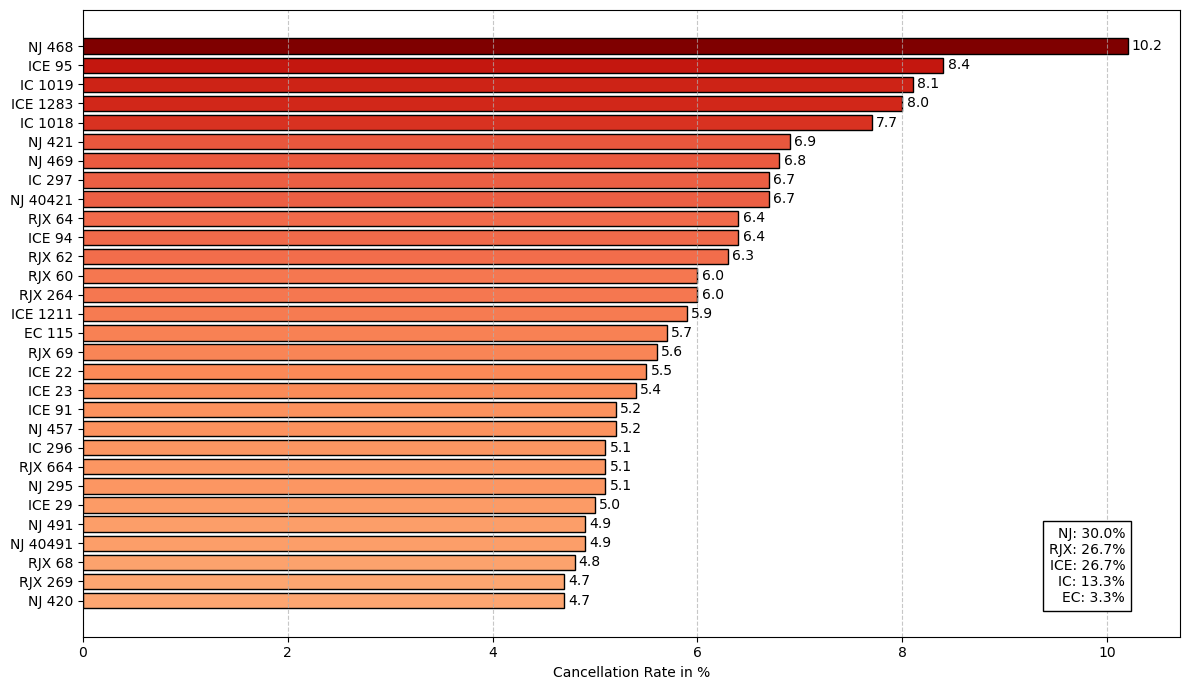

In [23]:
cancel_by_train = df_fern_cancel.group_by("Train Nr.").agg(
    pl.len().alias("cancel_count")
).filter(pl.col("cancel_count") > 50)
df_fern_total = df_fern.group_by("Train Nr.").agg(
    pl.len().alias("total_trips"),
    pl.col("Train Type").first().alias("Train Type") 
)
cancellation_rates = df_fern_total.join(cancel_by_train, on = "Train Nr.").with_columns(
    (pl.col("cancel_count") / pl.col("total_trips") * 100).round(1).alias("cancel_rate"),
    pl.col("Train Type")
).sort("cancel_rate", descending = True)
#print(cancellation_rates)

cancellation_rates_top = cancellation_rates.head(30)

train_type_count = cancellation_rates_top.group_by("Train Type").agg(
    pl.len().alias("count")
).with_columns(
    (pl.col("count") / cancellation_rates_top.height * 100).round(1).alias("percentage")
).sort("percentage", descending=True)

percentage_text = train_type_count.select(
    pl.format(
        "{}: {}%", 
        pl.col("Train Type"), 
        pl.col("percentage")
    )
).to_series().str.concat("\n")[0]

fig, ax = plt.subplots(figsize = (12, 7))

norm = plt.Normalize(cancellation_rates["cancel_rate"].min(), cancellation_rates["cancel_rate"].max())
colors = plt.cm.OrRd(norm(cancellation_rates["cancel_rate"]))
bars = ax.barh(cancellation_rates_top["Train Nr."].cast(pl.String), cancellation_rates_top["cancel_rate"], color = colors, edgecolor = "black")

ax.invert_yaxis()
ax.grid(axis = "x", linestyle = "--", alpha = 0.7)
ax.bar_label(bars, padding = 3, fmt = "%.1f")
ax.set_xlabel("Cancellation Rate in %")
ax.text(0.95, 0.05, 
        percentage_text, 
        transform = ax.transAxes, 
        fontsize=10,
        va = "bottom",
        ha = "right",
        bbox = dict(facecolor = "white", edgecolor = "black")
       )

plt.tight_layout()
plt.show()

Cancellation Rate by Station

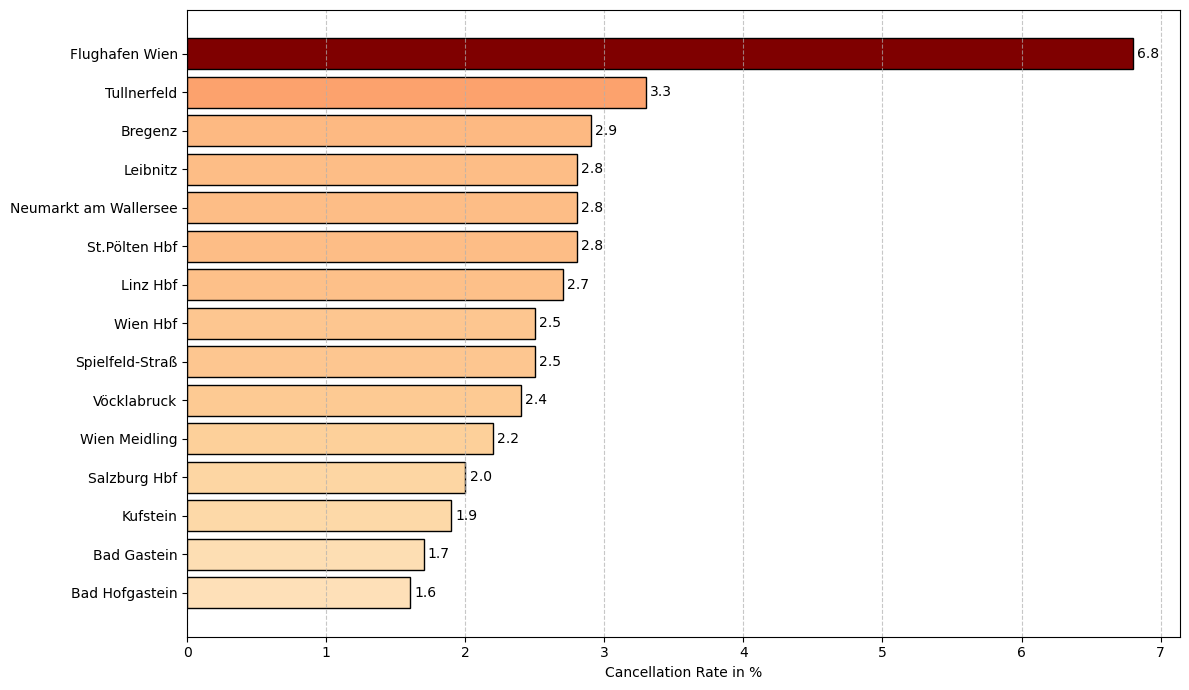

In [24]:
cancel_by_station = df_fern_cancel.group_by("Arrival Station").agg(
        pl.len().alias("cancel_count")
).filter(pl.col("cancel_count") > 100)
df_train_total = df_fern.group_by("Arrival Station").agg(
    pl.len().alias("total_station")
)
cancellation_rates = df_train_total.join(cancel_by_station, on = "Arrival Station").with_columns(
    (pl.col("cancel_count") / pl.col("total_station") * 100).round(1).alias("cancel_rate")
).sort("cancel_rate", descending = True)
#print(cancellation_rates)

cancel_by_station_top = cancellation_rates.head(15)

fig, ax = plt.subplots(figsize = (12, 7))

norm = plt.Normalize(cancellation_rates["cancel_rate"].min(), cancellation_rates["cancel_rate"].max())
colors = plt.cm.OrRd(norm(cancellation_rates["cancel_rate"]))
bars = ax.barh(cancel_by_station_top["Arrival Station"].cast(pl.String), cancel_by_station_top["cancel_rate"], color = colors, edgecolor = "black")

ax.invert_yaxis()
ax.grid(axis = "x", linestyle = "--", alpha = 0.7)
ax.bar_label(bars, padding = 3, fmt = "%.1f")
ax.set_xlabel("Cancellation Rate in %")

plt.tight_layout()
plt.show()

Cancellation Rate by Hour

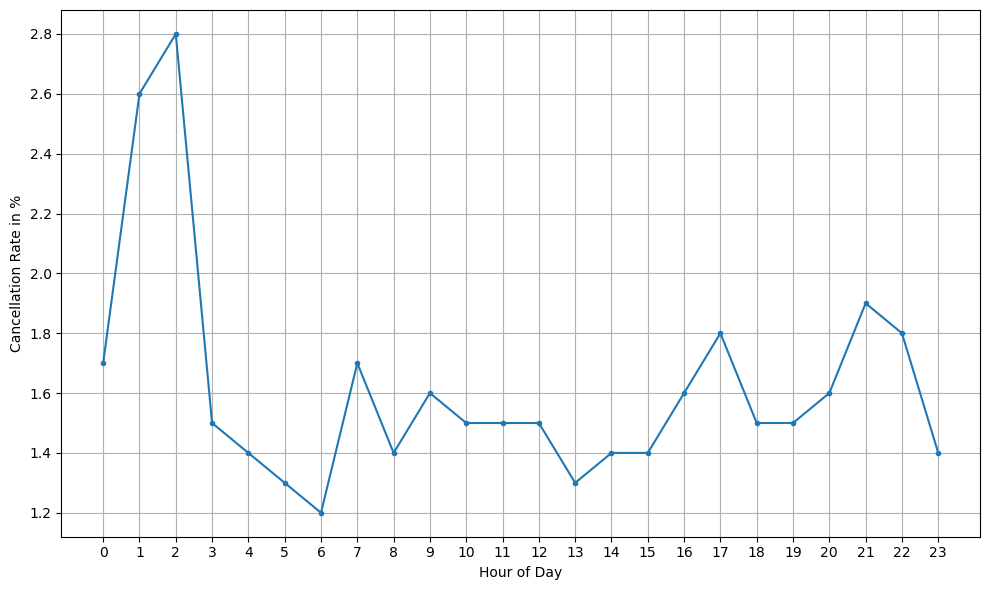

In [25]:
cancel_by_hour = df_fern_cancel.group_by("Arrival Hour").agg(
        pl.len().alias("cancel_count")
)
df_train_total = df_fern.group_by("Arrival Hour").agg(
    pl.len().alias("total_hour")
)
cancellation_rates = df_train_total.join(cancel_by_hour, on = "Arrival Hour").with_columns(
    (pl.col("cancel_count") / pl.col("total_hour") * 100).round(1).alias("cancel_rate")
).sort("Arrival Hour")
#print(cancellation_rates)

plt.figure(figsize = (10,6))
plt.plot(cancellation_rates["Arrival Hour"], cancellation_rates["cancel_rate"], marker = ".")
plt.xlabel("Hour of Day")
plt.ylabel("Cancellation Rate in %")
plt.xticks(range(0,24))
plt.grid(True)
plt.tight_layout()
plt.show()

Cancellation Rate by Day

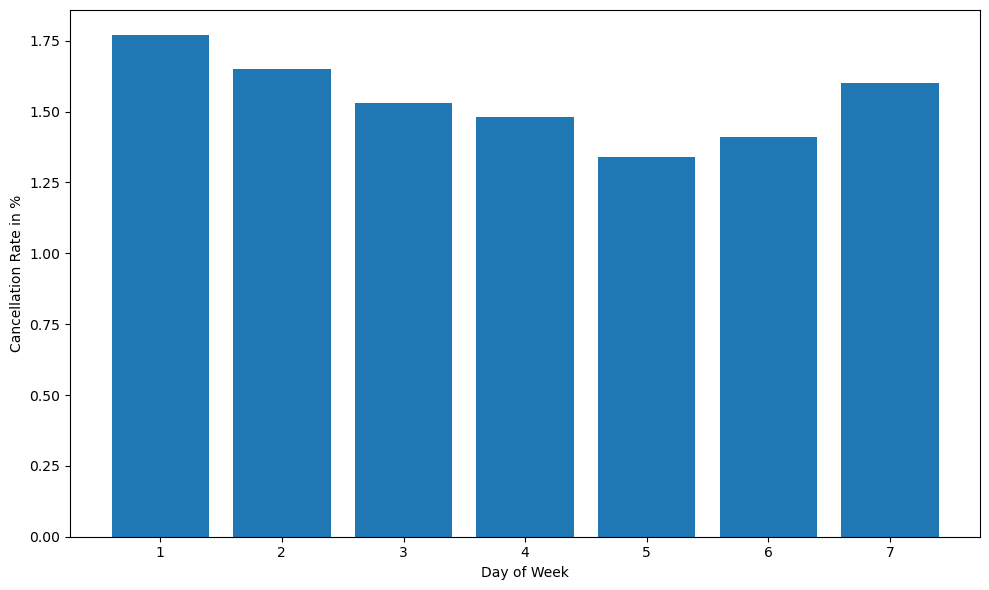

In [26]:
cancel_by_day = df_fern_cancel.group_by("Day of Week").agg(
    pl.len().alias("cancel_count")
).sort("Day of Week")
df_train_total = df_fern.group_by("Day of Week").agg(
    pl.len().alias("total_week")
)
cancellation_rates = df_train_total.join(cancel_by_day, on = "Day of Week").with_columns(
    (pl.col("cancel_count") / pl.col("total_week") * 100).round(2).alias("cancel_rate")
).sort("Day of Week")
#print(cancellation_rates)

plt.figure(figsize=(10,6))
plt.bar(cancellation_rates["Day of Week"], cancellation_rates["cancel_rate"])
plt.xlabel("Day of Week")
plt.ylabel("Cancellation Rate in %")
plt.tight_layout()
plt.show()

Cancellation Rate by Date

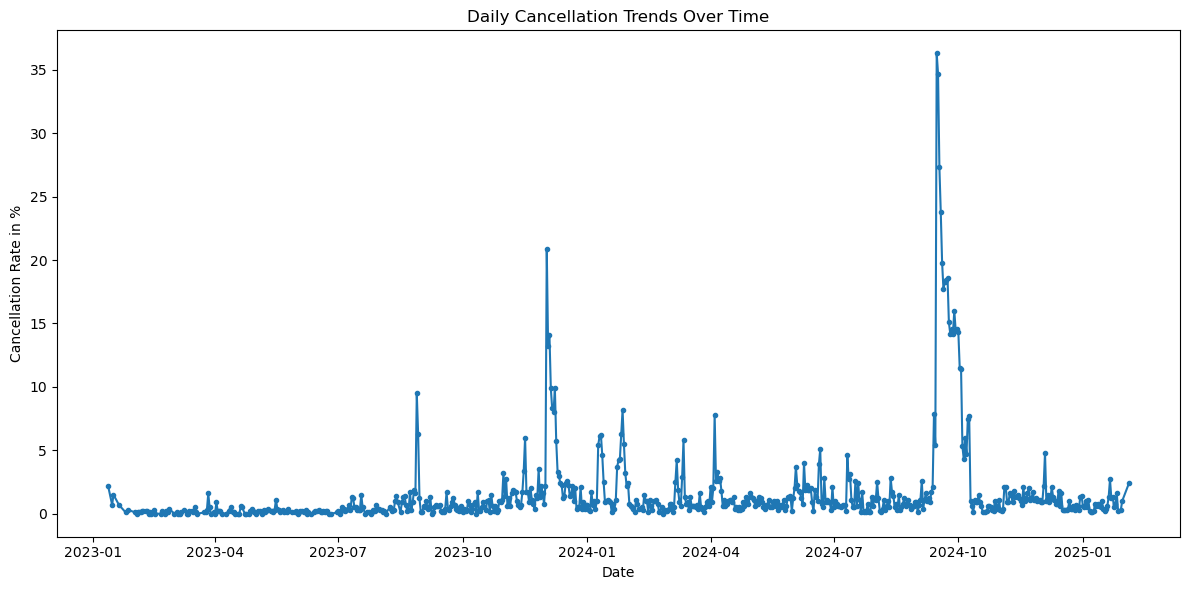

In [27]:
cancel_by_date = df_fern_cancel.group_by("Date").agg(
    pl.len().alias("cancel_count")
).sort("Date")
df_train_total = df_fern.group_by("Date").agg(
    pl.len().alias("total_date")
)
cancellation_rates = df_train_total.join(cancel_by_date, on = "Date").with_columns(
    (pl.col("cancel_count") / pl.col("total_date") * 100).round(1).alias("cancel_rate")
).sort("Date")
#print(cancellation_rates)

plt.figure(figsize = (12,6))
plt.plot(cancellation_rates["Date"], cancellation_rates["cancel_rate"], marker=".")
plt.xlabel("Date")
plt.ylabel("Cancellation Rate in %")
plt.title("Daily Cancellation Trends Over Time")
plt.tight_layout()
plt.show()

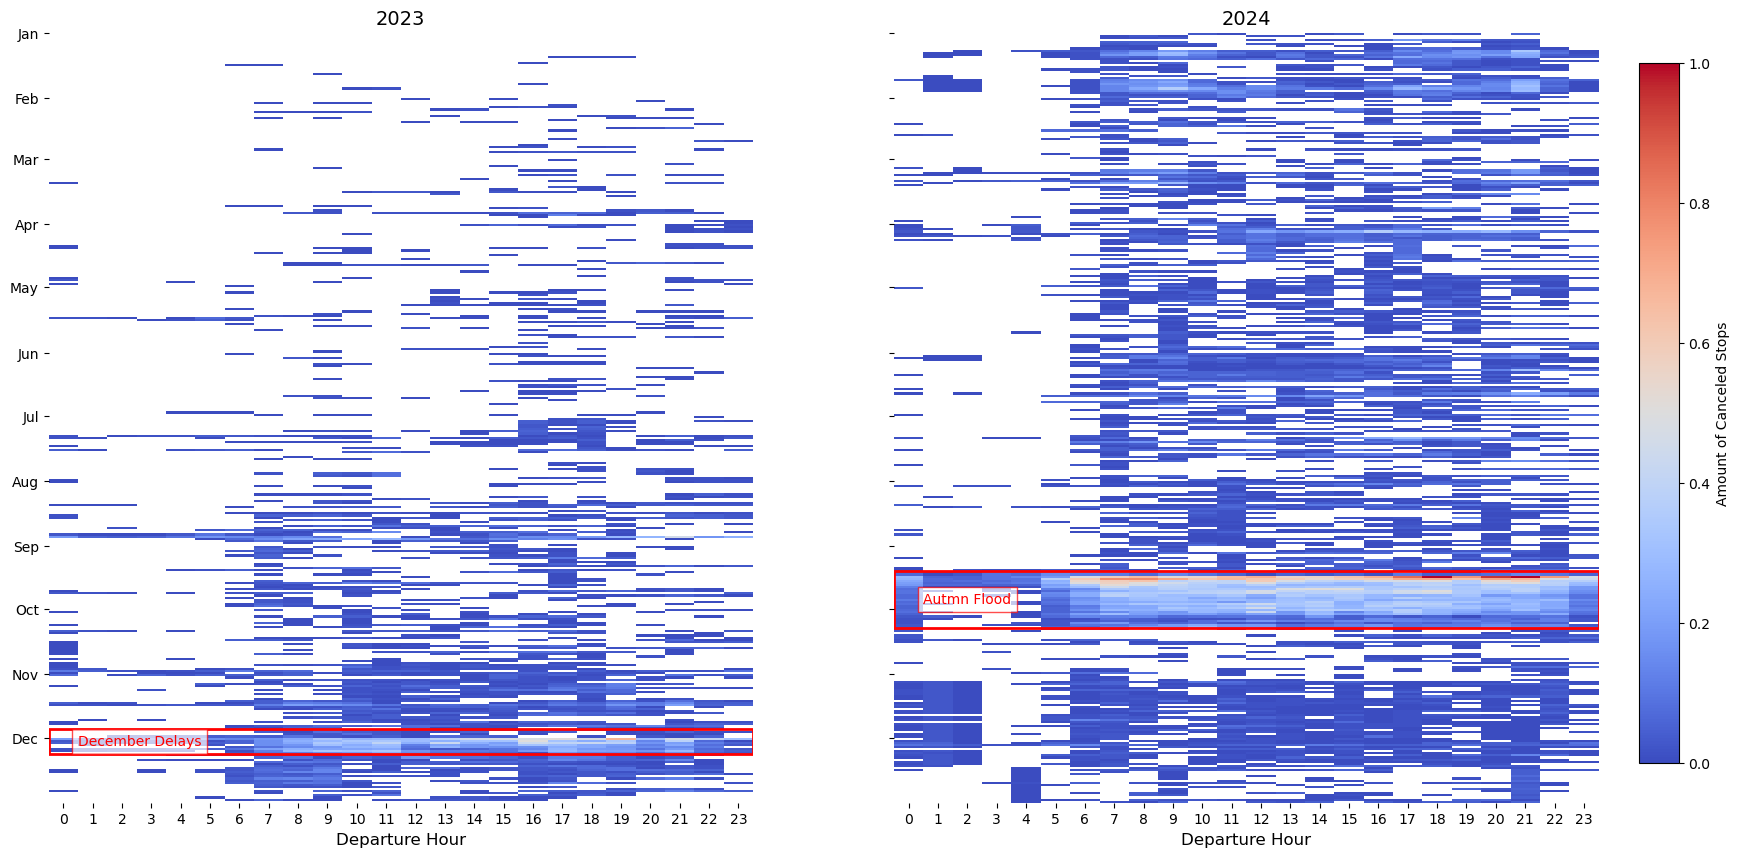

In [28]:
cancel_by_date_hour_2023 = df_fern_cancel.filter((pl.col("Year") == 2023)).group_by(["Date", "Arrival Hour"]).agg(
    pl.len().alias("cancel_count")
).sort(["Date", "Arrival Hour"])
cancel_by_date_hour_2024 = df_fern_cancel.filter((pl.col("Year") == 2024)).group_by(["Date", "Arrival Hour"]).agg(
    pl.len().alias("cancel_count")
).sort(["Date", "Arrival Hour"])

# Seaborn Heatmap needs pandas
cancel_by_date_hour_2023_pd = cancel_by_date_hour_2023.to_pandas()
cancel_by_date_hour_2024_pd = cancel_by_date_hour_2024.to_pandas()

heatmap_data_2023 = cancel_by_date_hour_2023_pd.pivot(index = "Date", columns = "Arrival Hour", values = "cancel_count")
heatmap_data_2024 = cancel_by_date_hour_2024_pd.pivot(index = "Date", columns = "Arrival Hour", values = "cancel_count")

# Make sure both years are of the same length
heatmap_data_2023.index = pd.to_datetime(heatmap_data_2023.index)
full_dates_2023 = pd.date_range(start = "2023-01-01", end = "2023-12-31", freq = "D")
heatmap_data_2023 = heatmap_data_2023.reindex(full_dates_2023)
heatmap_data_2024.index = pd.to_datetime(heatmap_data_2024.index)
full_dates_2024 = pd.date_range(start = "2024-01-01", end = "2024-12-31", freq = "D")
heatmap_data_2024 = heatmap_data_2024.reindex(full_dates_2024)

vmin = min(cancel_by_date_hour_2023_pd["cancel_count"].min(), 
           cancel_by_date_hour_2024_pd["cancel_count"].min())
vmax = max(cancel_by_date_hour_2023_pd["cancel_count"].max(), 
           cancel_by_date_hour_2024_pd["cancel_count"].max())
norm = plt.Normalize(vmin = vmin, vmax = vmax)

fig, axes = plt.subplots(1, 2, figsize = (20, 10), sharey = True)

# Heatmap 2023
sns.heatmap(
    heatmap_data_2023, 
    cmap = "coolwarm", 
    ax = axes[0], 
    cbar = False,  
    yticklabels = False,
    norm = norm,
    vmin = vmin,
    vmax = vmax
)
# Heatmap 2024
sns.heatmap(
    heatmap_data_2024, 
    cmap = "coolwarm", 
    ax = axes[1], 
    cbar = False, 
    yticklabels = False,
    norm = norm,
    vmin = vmin,
    vmax = vmax
)

# Legend
fig.colorbar(plt.cm.ScalarMappable(cmap = "coolwarm"), cax = fig.add_axes([0.92, 0.15, 0.02, 0.7]), label = "Amount of Canceled Stops")
# X-Axis
axes[0].set_title("2023", fontsize = 14)
axes[1].set_title("2024", fontsize = 14)
axes[0].set_xlabel("Departure Hour", fontsize = 12)
axes[1].set_xlabel("Departure Hour", fontsize = 12)
# Y-Axis
ticks = np.where(heatmap_data_2024.index.day == 1)[0]
labels = heatmap_data_2024.index[heatmap_data_2024.index.day == 1].strftime('%b')
axes[0].set_yticks(ticks)
axes[0].set_yticklabels(labels)
axes[0].invert_yaxis()
axes[1].invert_yaxis()

# Highlighting special events
highlight_23 = [
    ("2023-11-28", "2023-12-10", "December Delays")
]
for (start_str, end_str, note) in highlight_23:
    start_date = pd.to_datetime(start_str)
    end_date = pd.to_datetime(end_str)

    y0 = np.searchsorted(heatmap_data_2023.index, start_date)
    y1 = np.searchsorted(heatmap_data_2023.index, end_date)
    
    rect = patches.Rectangle(
        (0, y0), # Rectangle Placement
        24, # Width: Entire Day
        y1 - y0, # Hight: Time frame
        fill = False,
        edgecolor = "red",
        linewidth = 2,
    )
    axes[0].add_patch(rect)
    axes[0].text(
        x = 1,
        y = (y0 + y1) / 2,
        s = note,
        color = "red",
        va = "center",
        bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "red")
    )

highlight_24 = [
    ("2024-09-13", "2024-10-10", "Autmn Flood")
]

for (start_str, end_str, note) in highlight_24:
    start_date = pd.to_datetime(start_str)
    end_date = pd.to_datetime(end_str)

    y0 = np.searchsorted(heatmap_data_2024.index, start_date)
    y1 = np.searchsorted(heatmap_data_2024.index, end_date)
    
    rect = patches.Rectangle(
        (0, y0),
        24,
        y1 - y0,
        fill = False,
        edgecolor = "red",
        linewidth = 2,
    )
    axes[1].add_patch(rect)
    axes[1].text(
        x = 1,
        y = (y0 + y1) / 2,
        s = note,
        color = "red",
        va = "center",
        bbox = dict(facecolor = "white", alpha = 0.7, edgecolor = "red")
    )
plt.show()

### Comparison Cancel vs. Delay

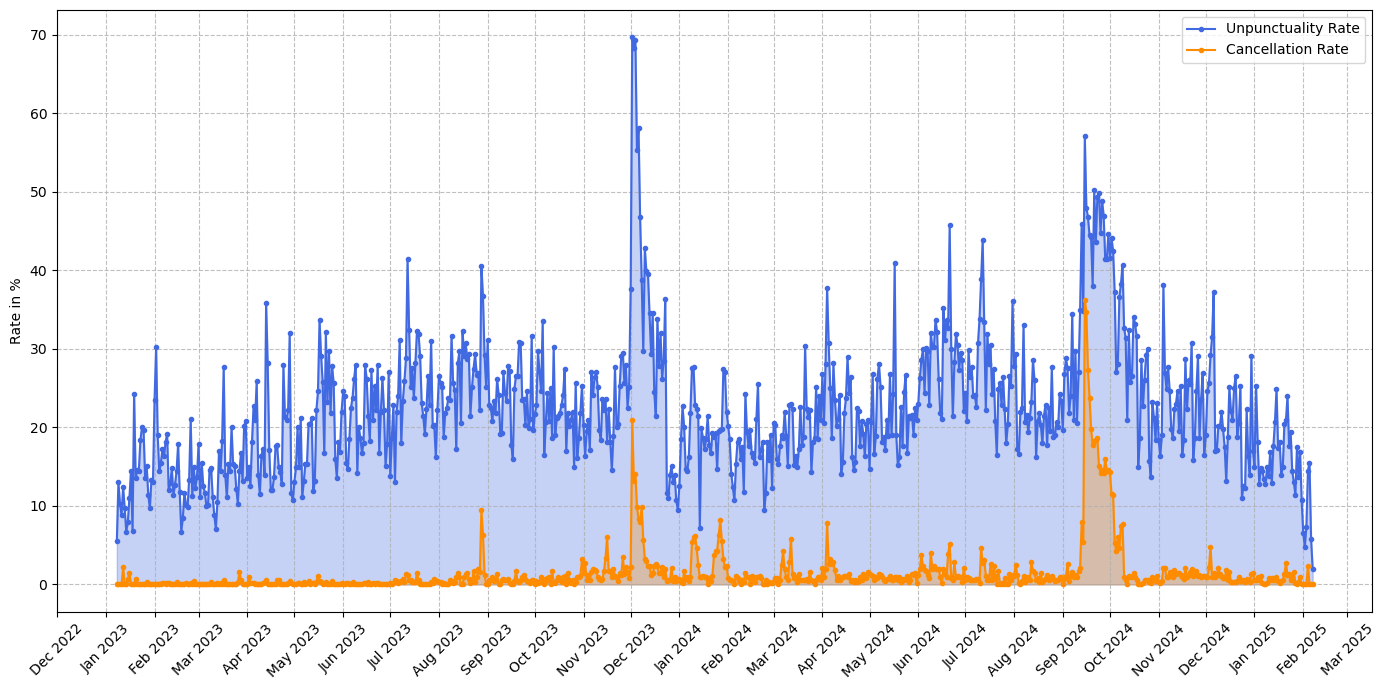

In [29]:
delay_cancel_count_by_date = df_fern.group_by("Date").agg([
    (pl.col("On Time") == 0).sum().alias("delay_count"),
    (pl.col("Cancellation") == 1).sum().alias("cancel_count"),
    pl.len().alias("total_stops")
]).sort("Date")
delay_cancel_count_by_date = delay_cancel_count_by_date.with_columns([
    (pl.col("delay_count") / pl.col("total_stops") * 100).round(1).alias("delay_rate"),
    (pl.col("cancel_count") / pl.col("total_stops") * 100).round(1).alias("cancel_rate")
])

plt.figure(figsize = (14, 7))

plt.plot(delay_cancel_count_by_date["Date"], delay_cancel_count_by_date["delay_rate"], color = "royalblue", marker = ".", label = "Unpunctuality Rate")
plt.plot(delay_cancel_count_by_date["Date"], delay_cancel_count_by_date["cancel_rate"], color = "darkorange", marker = ".", label = "Cancellation Rate")
plt.fill_between(delay_cancel_count_by_date["Date"], delay_cancel_count_by_date["delay_rate"], color = "royalblue", alpha = 0.3)
plt.fill_between(delay_cancel_count_by_date["Date"], delay_cancel_count_by_date["cancel_rate"], color = "darkorange", alpha = 0.3)

plt.ylabel("Rate in %") 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.grid(linestyle = "--", alpha = 0.8)
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

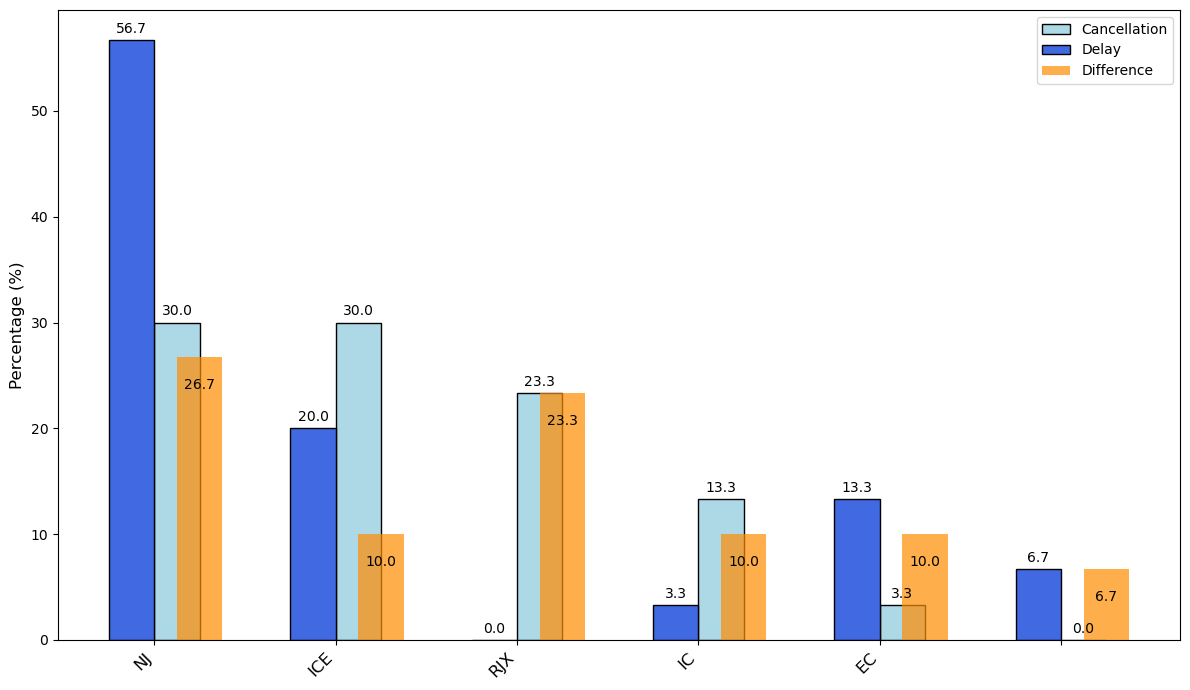

In [30]:
cancel_by_train = df_fern_cancel.group_by("Train Nr.").agg(
    pl.len().alias("cancel_count")
).filter(pl.col("cancel_count") > 50)

df_fern_total = df_fern.group_by("Train Nr.").agg(
    pl.len().alias("total_trips"),
    pl.col("Train Type").first().alias("Train Type")
)

cancellation_rates = df_fern_total.join(cancel_by_train, on = "Train Nr.").with_columns(
    (pl.col("cancel_count") / pl.col("total_trips") * 100).alias("cancel_rate")
).sort("cancel_rate", descending = True)

delay_by_train = df_fern_delay_without_cancel.group_by("Train Nr.").agg([
    pl.col("Delay").mean().round(1).alias("avg_delay"),
    pl.len().alias("ride_count"),
    pl.col("Train Type").first().alias("Train Type")
]).filter(pl.col("ride_count") > 50).drop("ride_count").sort("avg_delay", descending = True)

cancellation_rates_top = cancellation_rates.head(30)
delay_by_train_top = delay_by_train.head(30)

cancel_percentages = cancellation_rates_top.group_by("Train Type").agg(
    pl.len().alias("count")
).with_columns(
    (pl.col("count") / cancellation_rates_top.height * 100).round(1).alias("Cancellation")
).select(["Train Type", "Cancellation"])
delay_percentages = delay_by_train_top.group_by("Train Type").agg(
    pl.len().alias("count")
).with_columns(
    (pl.col("count") / delay_by_train_top.height * 100).round(1).alias("Delay")
).select(["Train Type", "Delay"])

merged_percentages = cancel_percentages.join(
    delay_percentages,
    on = "Train Type",
    how = "full"
).fill_null(0).with_columns(
    ((pl.col("Cancellation") - pl.col("Delay")).abs()).round(1).alias("Difference")
).sort(["Cancellation","Delay"], descending = True)


fig, ax = plt.subplots(figsize = (12, 7))
bar_width = 0.25
indices = range(len(merged_percentages))

pos_cancel = [i + bar_width / 2 for i in indices]
pos_delay  = [i - bar_width / 2 for i in indices]
pos_diff   = [i + bar_width  for i in indices]

bars_cancel = ax.bar(
    pos_cancel,
    merged_percentages["Cancellation"],
    width = bar_width,
    color = "lightblue",
    edgecolor = "black",
    label = "Cancellation"
)
bars_delay = ax.bar(
    pos_delay,
    merged_percentages["Delay"],
    width = bar_width,
    color = "royalblue",
    edgecolor = "black",
    label = "Delay"
)
bars_diff = ax.bar(
    pos_diff,
    merged_percentages["Difference"],
    width = bar_width,
    color = "darkorange",
    alpha = 0.7,
    label = "Difference"
)

for bars in [bars_cancel, bars_delay]:
    for bar in bars:
        ax.annotate(
            bar.get_height(),
            xy = (bar.get_x() + bar.get_width() / 2, bar.get_height()),
            xytext = (0, 3),
            textcoords = "offset points",
            ha = "center",
            va = "bottom" if bar.get_height() >= 0 else "top",
            fontsize = 10
        )
for bar in bars_diff:
    ax.annotate(
        bar.get_height(),
        xy = (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext = (0, -15 if bar.get_height() > 0 else 12),
        textcoords = "offset points",
        ha = "center",
        va = "top",
        fontsize = 10
    )

ax.set_xticks(indices)
ax.set_xticklabels(merged_percentages["Train Type"], rotation = 45, ha = "right", fontsize = 12)
ax.set_ylabel("Percentage (%)", fontsize = 12)
ax.legend(loc = "upper right")

plt.tight_layout()
plt.show()

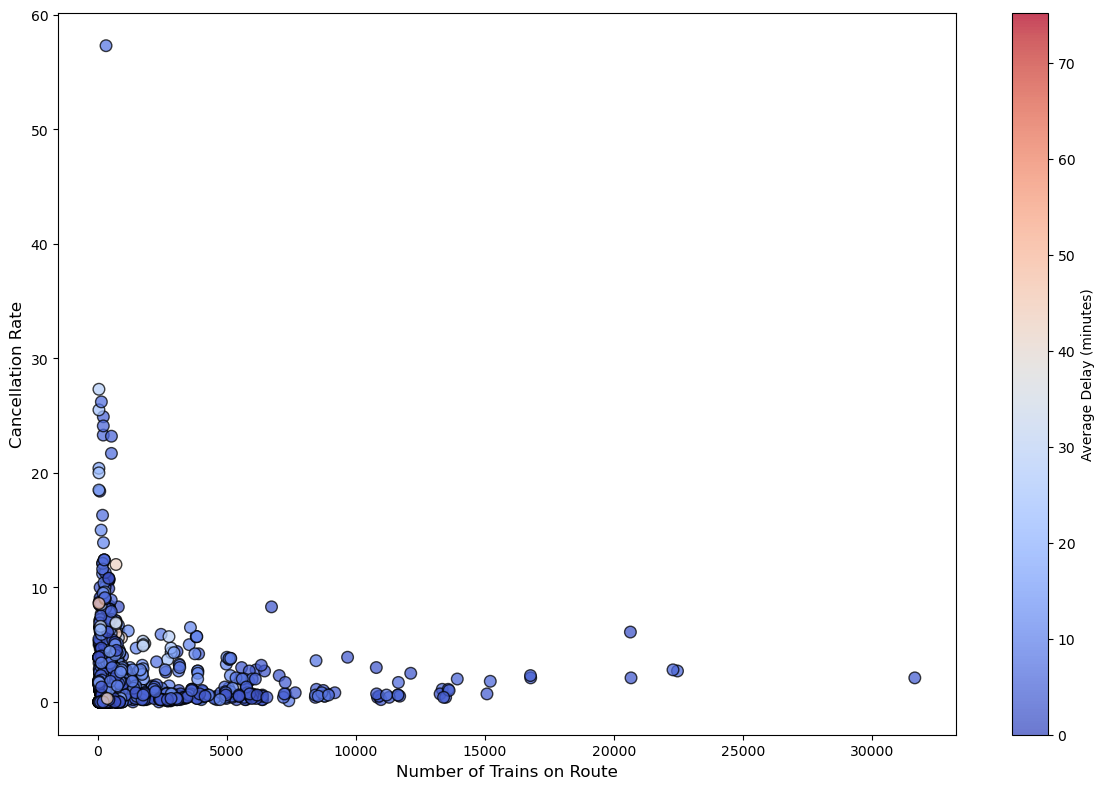

In [31]:
route_efficiency = df_fern.group_by(
    ["Departing Station", "Arrival Station"]
).agg([
    pl.count("Train Nr.").alias("num_trains"),
    pl.col("Delay").mean().round(1).alias("avg_delay"),
    (pl.col("Cancellation") == 1).sum().alias("cancel_count")
]).filter(pl.col("num_trains") > 50)

route_efficiency = route_efficiency.with_columns(
    (pl.col("cancel_count") / pl.col("num_trains") * 100).round(1).alias("cancel_rate")
)

fig, ax = plt.subplots(figsize = (12, 8))

scatter = ax.scatter(
    route_efficiency["num_trains"],
    route_efficiency["cancel_rate"],
    c = route_efficiency["avg_delay"],
    cmap = "coolwarm",  
    s = 70,            
    alpha = 0.75,      
    edgecolor = "black"    
)

cbar = plt.colorbar(scatter, ax = ax)
cbar.set_label("Average Delay (minutes)")

ax.set_xlabel("Number of Trains on Route", fontsize = 12)
ax.set_ylabel("Cancellation Rate", fontsize = 12)

plt.tight_layout()
plt.show()

#### Difference in stops between 2023 and 2024

In [32]:
len(df_fern.filter(pl.col("Year") == 2024)) - len(df_fern.filter(pl.col("Year") == 2023))

112298

### Station Performance Analysis

Station Punctuality

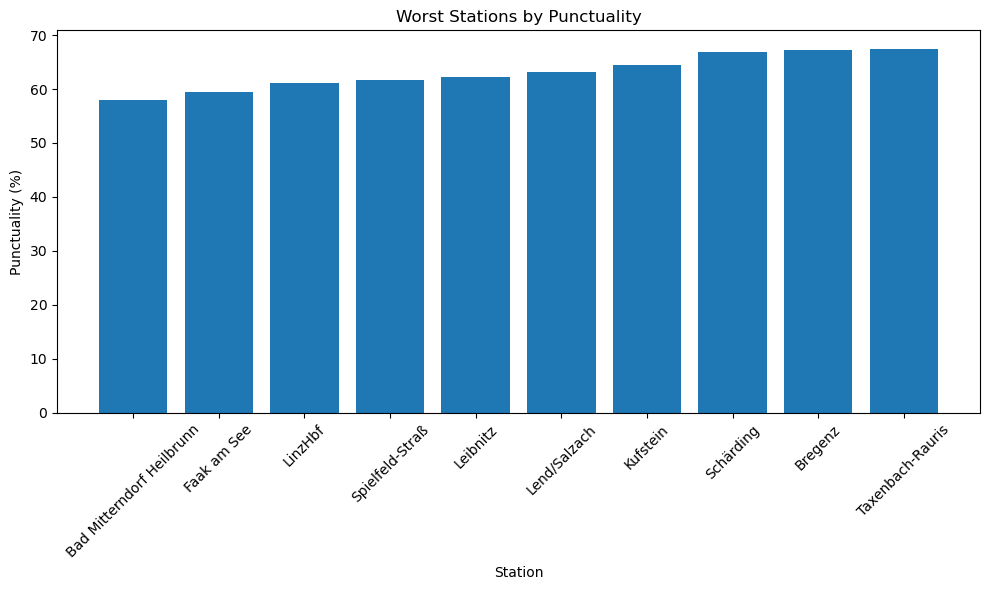

In [33]:
station_punc = df_fern.group_by("Arrival Station").agg([
    (pl.col("On Time").mean() * 100).round(1).alias("punc_percentage"),
    pl.len().alias("station_count") 
]).filter(pl.col("station_count") > 100).drop("station_count").sort("punc_percentage", descending = False).head(10)
#print(station_punc)

plt.figure(figsize = (10,6))

plt.bar(station_punc["Arrival Station"], station_punc["punc_percentage"])

plt.xlabel("Station")
plt.ylabel("Punctuality (%)")
plt.title("Worst Stations by Punctuality")
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

### Train Analysis

Train Reliability

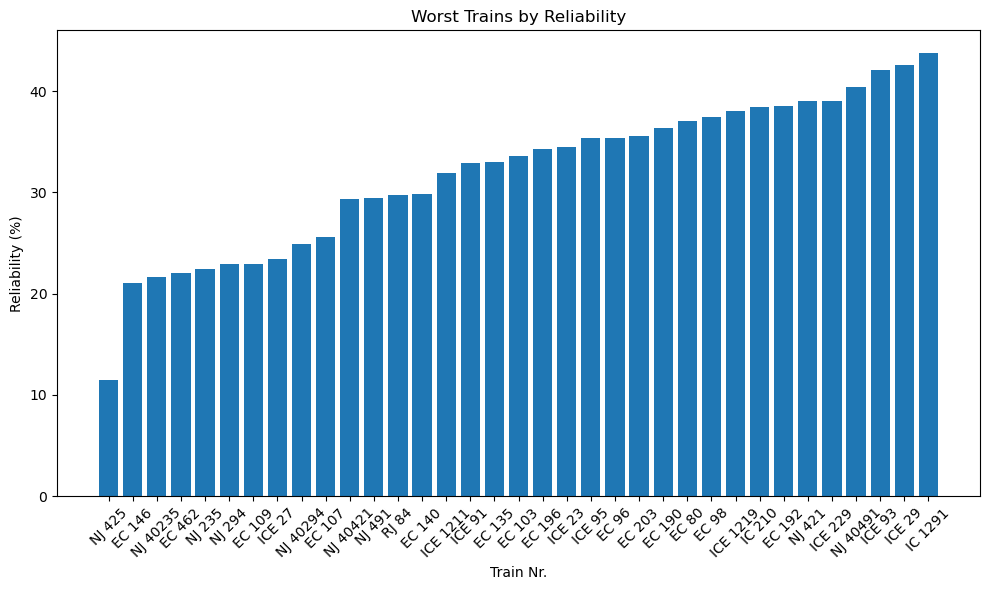

In [34]:
train_reliability = df_fern.group_by("Train Nr.").agg([
    (pl.col("On Time").mean() * 100).round(1).alias("reliability_percentage"),
    pl.len().alias("train_count") 
]).filter(pl.col("train_count") > 365).drop("train_count").sort("reliability_percentage", descending = False).head(35)
#print(train_reliability)

plt.figure(figsize = (10,6))

plt.bar(train_reliability["Train Nr."], train_reliability["reliability_percentage"])

plt.xlabel("Train Nr.")
plt.ylabel("Reliability (%)")
plt.title("Worst Trains by Reliability")
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

### Route Performance Analysis

Highest Delayed Routes

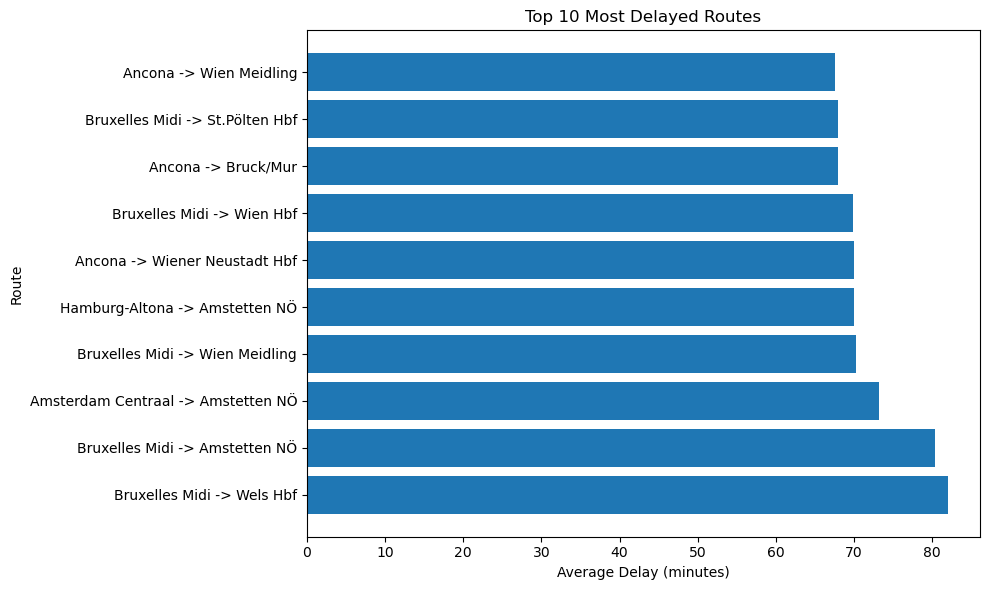

In [35]:
route_delays = df_fern_delay_without_cancel.group_by(
    ["Departing Station", "Arrival Station"]
).agg(
    pl.col("Delay").mean().round(1).alias("avg_delay"),
    pl.len().alias("station_count") 
).filter(pl.col("station_count") > 50).drop("station_count").sort("avg_delay", descending = True)

route_delays = route_delays.with_columns(
    (pl.col("Departing Station") + " -> " + pl.col("Arrival Station")).alias("connection")
).head(10)
#print(route_delays)

plt.figure(figsize = (10,6))

plt.barh(route_delays["connection"], route_delays["avg_delay"])

plt.xlabel("Average Delay (minutes)")
plt.ylabel("Route")
plt.title("Top 10 Most Delayed Routes")

plt.tight_layout()
plt.show()

Most Delayed Routes

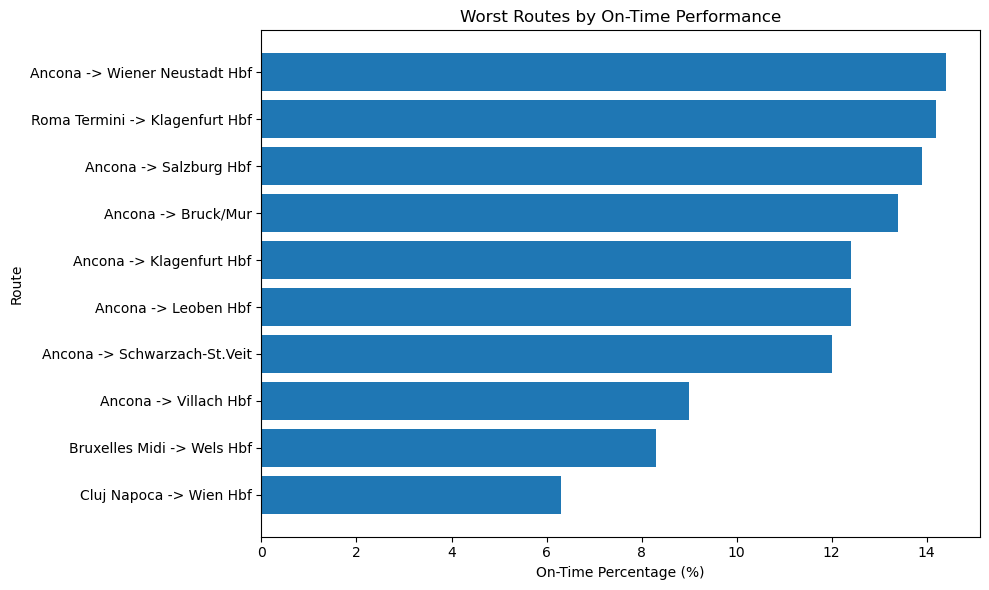

In [36]:
route_ontime = df_fern.group_by(
    ["Departing Station", "Arrival Station"]
).agg(
    (pl.col("On Time").mean() * 100).round(1).alias("on_time_percentage"),
    pl.len().alias("station_count") 
).filter(pl.col("station_count") > 50).drop("station_count").sort("on_time_percentage", descending = False)

route_ontime = route_ontime.with_columns(
    (pl.col("Departing Station") + " -> " + pl.col("Arrival Station")).alias("connection")
).head(10)
#print(route_ontime)

plt.figure(figsize = (10,6))

plt.barh(route_ontime["connection"], route_ontime["on_time_percentage"])

plt.xlabel("On-Time Percentage (%)")
plt.ylabel("Route")
plt.title("Worst Routes by On-Time Performance")

plt.tight_layout()
plt.show()

WIP: With GTFS Destination

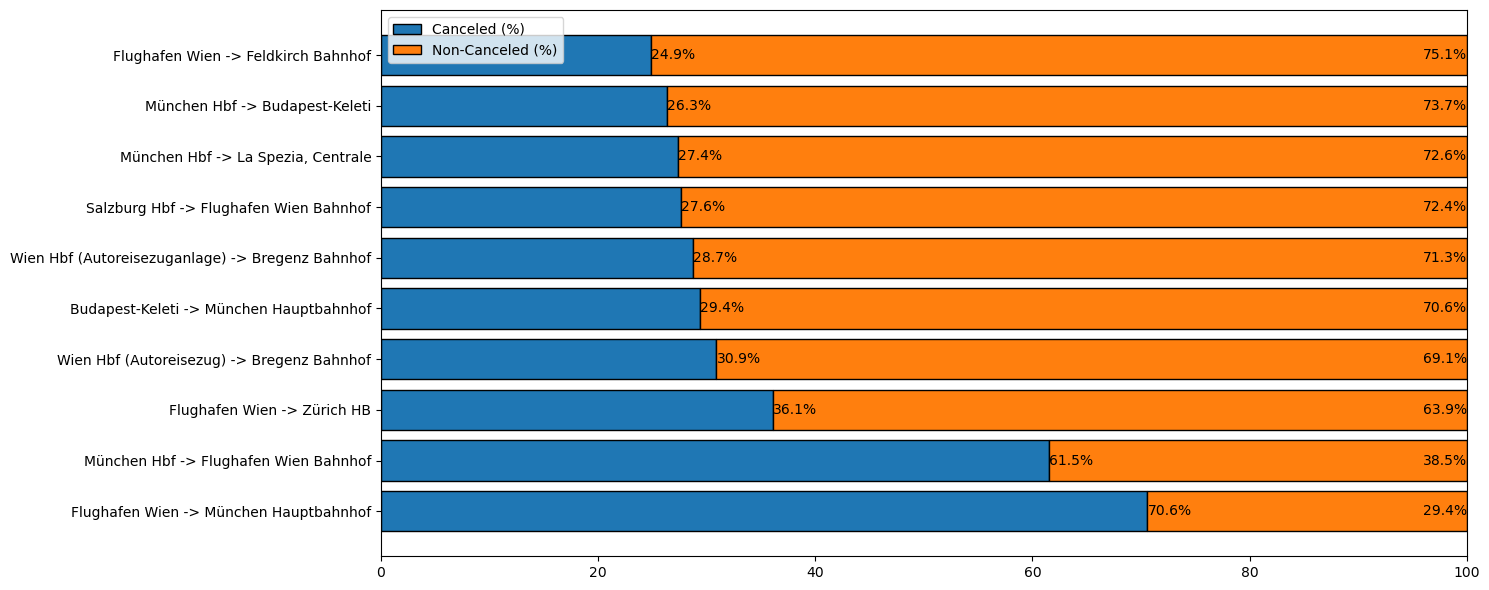

In [39]:
# Get Connection frequency
route_all = df_dest_val.unique(
    subset = ["Departing Station", "Destination", "Train Nr.", "Date"]
).group_by(["Departing Station", "Destination"]).agg([
    pl.len().alias("connection_frequency")
]).filter(pl.col("connection_frequency") > 150).sort("connection_frequency", descending = True)

# Get Cancellation frequency
route_canceled = df_dest_val.filter(pl.col("Cancellation") == 1).unique(
    subset = ["Departing Station", "Destination", "Train Nr.", "Date"]
).group_by(["Departing Station", "Destination"]).agg([
    pl.len().alias("canceled_frequency")
])

route = route_all.join(
    route_canceled,
    on = ["Departing Station", "Destination"],
    how = "left"
).fill_null(0)

# calculate percentages
route = route.with_columns(
    (pl.col("Departing Station") + " -> " + pl.col("Destination")).alias("connection"),
    ((pl.col("canceled_frequency") / pl.col("connection_frequency")) * 100).round(1).alias("canceled_percentage")
)
route = route.with_columns(
    (100 - pl.col("canceled_percentage")).round(1).alias("non_canceled_percentage")
).sort("canceled_percentage", descending = True).head(10)


plt.figure(figsize=(15, 6))

plt.barh(route["connection"], route["canceled_percentage"], edgecolor = "black", label = "Canceled (%)")
plt.barh(route["connection"], route["non_canceled_percentage"], edgecolor = "black", left = route["canceled_percentage"], label = "Non-Canceled (%)")

for index, row in enumerate(route.iter_rows(named = True)):
    canceled_pct = row["canceled_percentage"]
    non_canceled_pct = row["non_canceled_percentage"]
    
    if canceled_pct > 0:
        plt.text(canceled_pct, index, f"{canceled_pct}%", 
                 va = "center", ha = "left", color = "black", fontsize = 10)
    if non_canceled_pct > 0:
        plt.text(canceled_pct + non_canceled_pct, index, f"{non_canceled_pct}%", 
                 va = "center", ha = "right", color = "black", fontsize = 10)

plt.xlim(0, 100)
plt.legend()

plt.tight_layout()
plt.show()

### Journey Analysis

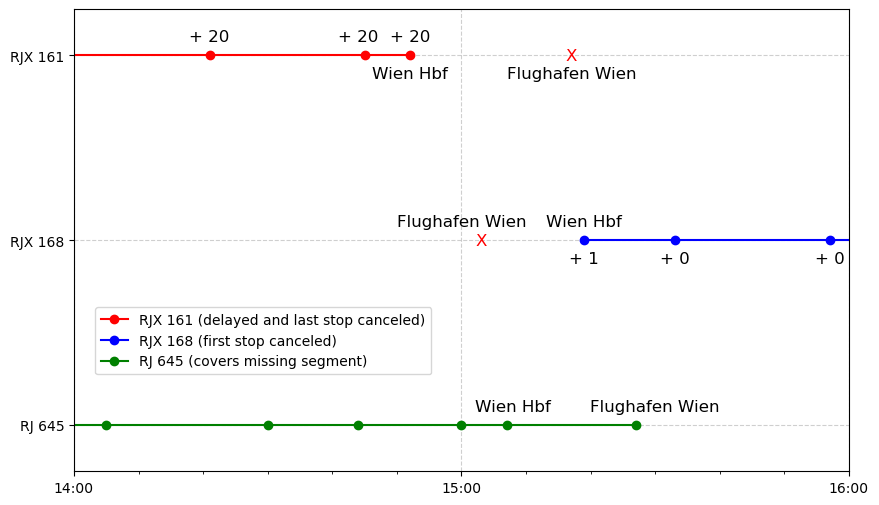

In [50]:
# Get specific trains
train1 = df_dest_val.filter((pl.col("Train Nr.") == "RJX 161") & (pl.col("Date") == pl.date(2023, 10, 8)) & (pl.col("Arrival Station") != "Flughafen Wien")).sort("Scheduled Arrival Time", descending = True)
train2 = df_dest_val.filter((pl.col("Train Nr.") == "RJX 168") & (pl.col("Date") == pl.date(2023, 10, 8))).sort("Scheduled Arrival Time", descending = True)
train3 = df_dest_val.filter((pl.col("Train Nr.") == "RJ 645") & (pl.col("Date") == pl.date(2023, 10, 8))).sort("Scheduled Arrival Time", descending = True)

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(train1["Actual Arrival Time"], [3] * len(train1["Actual Arrival Time"]), color = "red", marker = "o", linestyle = "-", label = "RJX 161 (delayed and last stop canceled)")
ax.plot(train2["Actual Arrival Time"], [2] * len(train2["Actual Arrival Time"]), color = "blue", marker = "o", linestyle = "-", label = "RJX 168 (first stop canceled)")
ax.plot(train3["Actual Arrival Time"], [1] * len(train3["Actual Arrival Time"]), color = "green", marker = "o", linestyle = "-", label = "RJ 645 (covers missing segment)")

# Include canceled stop
ax.text(dt(2023, 10, 8, 15, 17), 3, "X", color = "red", fontsize = 12, ha = "center", va = "center")
ax.text(dt(2023, 10, 8, 15, 3), 2, "X", color = "red", fontsize = 12, ha = "center", va = "center")

# Naming
ax.text(dt(2023, 10, 8, 14, 52), 2.9, "Wien Hbf", color = "black", fontsize = 12, ha = "center", va = "center")  
ax.text(dt(2023, 10, 8, 15, 17), 2.9, "Flughafen Wien", color = "black", fontsize = 12, ha = "center", va = "center")  
ax.text(dt(2023, 10, 8, 15, 19), 2.1, "Wien Hbf", color = "black", fontsize = 12, ha = "center", va = "center")  
ax.text(dt(2023, 10, 8, 15, 0), 2.1, "Flughafen Wien", color = "black", fontsize = 12, ha = "center", va = "center")  
ax.text(dt(2023, 10, 8, 15, 8), 1.1, "Wien Hbf", color = "black", fontsize = 12, ha = "center", va = "center")  
ax.text(dt(2023, 10, 8, 15, 30), 1.1, "Flughafen Wien", color = "black", fontsize = 12, ha = "center", va = "center")

# Delay
ax.text(dt(2023, 10, 8, 14, 52), 3.1, "+ 20", color = "black", fontsize = 12, ha = "center", va = "center")  
ax.text(dt(2023, 10, 8, 14, 21), 3.1, "+ 20", color = "black", fontsize = 12, ha = "center", va = "center")  
ax.text(dt(2023, 10, 8, 14, 44), 3.1, "+ 20", color = "black", fontsize = 12, ha = "center", va = "center")  
ax.text(dt(2023, 10, 8, 15, 19), 1.9, "+ 1", color = "black", fontsize = 12, ha = "center", va = "center")  
ax.text(dt(2023, 10, 8, 15, 33), 1.9, "+ 0", color = "black", fontsize = 12, ha = "center", va = "center") 
ax.text(dt(2023, 10, 8, 15, 57), 1.9, "+ 0", color = "black", fontsize = 12, ha = "center", va = "center")  

ax.set_yticks([1, 2, 3])
ax.set_yticklabels(["RJ 645", "RJX 168", "RJX 161"])
ax.legend(bbox_to_anchor = (0.47, 0.37))
ax.grid(linestyle = "--", alpha = 0.6)
ax.set_xlim([dt(2023, 10, 8, 14, 0), dt(2023, 10, 8, 16, 0)])
ax.set_ylim(0.75, 3.25)
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval = 10))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.show()

In [51]:
import pandas as pd

stationen = pd.read_csv("./Data/Verzeichnis der Verkehrsstationen.csv", sep = ";")
stationen = stationen.drop(range(1038,1058)) #these are NaNs
replace_map = {
    " a.d.L.": "/Leitha",
    " a.d.": "/", 
    " a d": "/",
    "N.Ö.": "NÖ",
    #"St.": "St. ",
    "Westbf": "Westbahnhof",
    "Ostbf": "Ostbahnhof",
    "Obertrattnach-M Hofk": "Obertrattnach-Markt Hofkirchen",
    "Wien Hauptbahnhof, Wien Hauptbahnhof Südtiroler Platz": "Wien Hbf",
    "Wien Mitte, Wien Mitte - CAT": "Wien Mitte",
    "Wörthersee": "Wörther See"
}

def replace_text(text):
    for old, new in replace_map.items():
        text = text.replace(old, new)
    return text
    
stationen["Verkehrsstation"] = stationen["Verkehrsstation"].apply(replace_text)
stations = sorted(stationen["Verkehrsstation"].tolist())

In [52]:
df_fern_austria = df_fern.filter(pl.col("Departing Station").is_in(stations))
df_fern_austria_delay_without_cancel = df_fern_austria.filter((pl.col("On Time") == 0) & (pl.col("Cancellation") == 0))
df_fern_austria

Searched Station,Date,Train Nr.,Train Type,Departing Station,Scheduled Departure Time,Arrival Station,Scheduled Arrival Time,Actual Arrival Time,Delay,Cancellation,On Time,Departure Hour,Arrival Hour,Day of Week,Month,Year,Station Latitude,Station Longitude
str,date,str,str,str,datetime[μs],str,datetime[μs],datetime[μs],i64,i32,i32,i8,i8,i8,i8,i32,f64,f64
"""Landeck_Zams""",2024-09-30,"""RJX 869""","""RJX""","""Bregenz""",2024-09-30 12:40:00,"""Landeck-Zams""",2024-09-30 14:25:00,2024-09-30 14:27:00,2,0,1,12,14,1,9,2024,47.148287,10.578534
"""Wels_Hbf""",2023-09-02,"""RJ 742""","""RJ""","""Wien Hbf""",2023-09-02 16:45:00,"""Wels Hbf""",2023-09-02 18:44:00,2023-09-02 18:45:00,1,0,1,16,18,6,9,2023,48.165701,14.026241
"""Salzburg_Hbf""",2023-06-03,"""RJX 861""","""RJX""","""Innsbruck Hbf""",2023-06-03 01:00:00,"""Salzburg Hbf""",2023-06-03 09:02:00,2023-06-03 09:02:00,0,0,1,1,9,6,6,2023,47.813073,13.045308
"""Kitzbühel""",2024-07-12,"""RJX 1062""","""RJX""","""Wien Hbf""",2024-07-12 09:51:00,"""Kitzbühel""",2024-07-12 15:13:00,2024-07-12 15:13:00,0,0,1,9,15,5,7,2024,47.453964,12.39102
"""Wien_Hbf""",2024-10-15,"""RJ 745""","""RJ""","""Salzburg Hbf""",2024-10-15 17:11:00,"""Wien Hbf""",2024-10-15 20:32:00,2024-10-15 20:32:00,0,0,1,17,20,2,10,2024,48.185332,16.37865
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Schwarzach_St._Veit""",2024-09-02,"""RJX 1530""","""RJX""","""Wien Hbf""",2024-09-02 19:28:00,"""Schwarzach-St.Veit""",2024-09-02 23:19:00,2024-09-02 23:20:00,1,0,1,19,23,1,9,2024,47.318913,13.154354
"""Traun""",2024-12-08,"""IC 507""","""IC""","""Linz Hbf""",2024-12-08 11:55:00,"""Traun OÖ""",2024-12-08 12:03:00,2024-12-08 12:03:00,0,0,1,11,12,7,12,2024,48.22545,14.253254
"""Kuchl""",2025-01-02,"""IC 794""","""IC""","""Salzburg Hbf""",2025-01-02 21:12:00,"""Kuchl""",2025-01-02 21:33:00,2025-01-02 21:38:00,5,0,1,21,21,4,1,2025,47.624937,13.142155


In [53]:
df_fern_delay_austria_2024 = df_fern_austria_delay_without_cancel.filter(pl.col("Year") == 2024)
df_fern_austria_2024 = df_fern_austria.filter(pl.col("Year") == 2024)
df_fern_delay_austria_2023 = df_fern_austria_delay_without_cancel.filter(pl.col("Year") == 2023)
df_fern_austria_2023 = df_fern_austria.filter(pl.col("Year") == 2023)

punc_2024 = (1 - len(df_fern_delay_austria_2024) / len(df_fern_austria_2024)) * 100
punc_2023 = (1 - len(df_fern_delay_austria_2023) / len(df_fern_austria_2023)) * 100

print("Punctuality 2023 (ÖBB): 80,3 %; Punctuality 2023 (Calculated):", punc_2023, "%")
print("Punctuality 2024 (ÖBB): 81 %; Punctuality 2024 (Calculated):", punc_2024, "%")

Punctuality 2023 (ÖBB): 80,3 %; Punctuality 2023 (Calculated): 83.9855301491734 %
Punctuality 2024 (ÖBB): 81 %; Punctuality 2024 (Calculated): 82.22575703175178 %


The Trains still make stops in Austria